In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

# Running selection function

In [2]:
folder = '/home/andy/Documents/Research/SF/SFdata/Galaxia_data/'
iso_folder = '/home/andy/Documents/Research/SF/SFdata/'

In [3]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import StatisticalModels as sm

In [4]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import SelectionGrid, IsochroneScaling, StatisticalModels, SFInstanceClasses

## New selection functions

In [281]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    # Probability of inclusion
    p = 1-1/(1+np.exp(-(field_data[:,0]-14.5)*5))
    p[field_data[:,0]<13.7] = 1.
    survive = np.random.rand(field_data.shape[0])<p
    
    return field_data[survive]

In [282]:
def get_spectro_flat(field):
    
    # Get photometric data
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    # Probability of inclusion
    p = np.zeros(field_data.shape[0]) + 0.1
    p[field_data[:,0]>13.5] = 0.
    p[field_data[:,1]<0.5] = 0.
    survive = np.random.rand(field_data.shape[0])<p
    
    return field_data[survive]

def get_spectro_tanh(field):
    
    # Get photometric data
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    # Probability of inclusion
    p = 0.5 * (1-np.tanh((field_data[:,0]-13.5+0.1)/np.exp(-3)))/2\
            * (1+np.tanh((field_data[:,1]-0.5)/np.exp(-2)))/2
    
    print(p)
    
    survive = np.random.rand(field_data.shape[0])<p
    
    return field_data[survive]

In [283]:
# Get photometric data
file_path = folder + '/photometric/'+str(2.0)+'.csv'
field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
field_data['Colour'] = field_data.Japp - field_data.Kapp
field_data = np.array(field_data[['Happ', 'Colour']])

In [274]:
field_data.shape[0]

8198

In [275]:
get_spectro_tanh(2.0).shape

[2.56282562e-02 4.90626300e-01 6.24332845e-11 ... 3.90330539e-01
 0.00000000e+00 4.82375764e-01]


(767, 2)

In [262]:
# Probability of inclusion
p = 1/(1+np.exp(-(instdf.x+14)))

In [270]:
1-1/(1+np.exp(-(13.5-14.5)*10))

0.9999546021312976

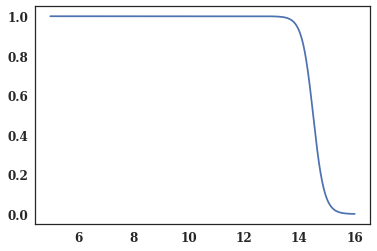

In [268]:
x_test = np.linspace(5, 16, 1000)
# Probability of inclusion
p = 1-1/(1+np.exp(-(x_test-14.5)*5))
plt.plot(x_test, p)

In [286]:
pointings = pointings[1:]
pointings.Magmin = 'NoLimit'
pointings.Magmax = 'NoLimit'
pointings.Colmin = 'NoLimit'

In [287]:
SF = SelectionGrid.SFGenerator(get_spectro_tanh, get_photo, pointings, 
                              spectro_model=('BGM_TNC', None), photo_model=('BGM_TNC', None))

The spectro model description is:('BGM_TNC', None)
The photo model description is:('BGM_TNC', None)


In [288]:
pointings

fieldID      glon      glat  halfangle   Magmin   Magmax   Colmin   Colmax
2      3.0  0.523599  1.064651   0.034907  NoLimit  NoLimit  NoLimit  NoLimit

In [18]:
%%time
# Load in the isochrone interpolant
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(iso_folder+'isochrones/isochrone_interpolantinstances.pickle')

ImportError: No module named 'dill.dill'

In [289]:
x_test = get_photo(3.0)

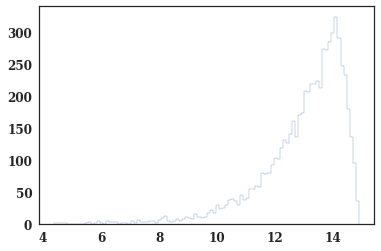

In [292]:
_=plt.hist(x_test[:,0], bins=100, histtype='step')

## Generate new selection functions

In [293]:
%time SF.gen_obsSF(folder+'/Galaxia_obsSF.pickle')

Creating colour-magnitude field interpolants...
Finished col-mag calculation: 3.0, 1/1, Time: 0.00m, Left: 0.00m[0.4906263  0.48876894 0.48604869 ... 0.28047838 0.39033054 0.        ]
('N stars = ', 6118)
Running BGM
(2, '  BIC: ', -62508.36052070313, '   lnP: ', 31306.49420349983)
(3, '  BIC: ', -63752.78831019539, '   lnP: ', 31954.865069820095)
(4, '  BIC: ', -65232.461003538476, '   lnP: ', 32720.858388065768)
(5, '  BIC: ', -65500.308166252944, '   lnP: ', 32880.93894099713)
(6, '  BIC: ', -65795.65509232788, '   lnP: ', 33054.76937560874)
(7, '  BIC: ', -66051.83816996055, '   lnP: ', 33209.0178859992)
(8, '  BIC: ', -66196.00993872854, '   lnP: ', 33307.26074195733)
(9, '  BIC: ', -66277.2165922491, '   lnP: ', 33374.021040291744)
(10, '  BIC: ', -66310.57546002752, '   lnP: ', 33416.857445755086)
(11, '  BIC: ', -66320.48209629339, '   lnP: ', 33447.96773546215)
(12, '  BIC: ', -66285.95498724576, '   lnP: ', 33456.86115251247)
(13, '  BIC: ', -66229.01212104672, '   lnP: ', 33

In [460]:
%time SF.debug_mode(3.0, part='sf')

AttributeError: 'SFGenerator' object has no attribute 'obsSF'

In [294]:
instsf = SF.obsSF[3.0].SF_model
instdf = SF.obsSF[3.0].DF_model
params_df = instsf.params_df

In [62]:
priorParams = StatisticalModels.NIW_prior_params(instsf.prior_sfBounds)
sampler = instsf.optimize(priorParams, 'emcee', niter=1000)

emcee with 1000 iterations...


In [16]:
phot = pd.read_csv('/home/andy/Documents/Research/data/asfe2/Projects/sf_data/Galaxia_data/photometric/3.0.csv')
x = phot.Happ
y = phot.Japp-phot.Kapp
xs = (x-instsf.mux)/instsf.sx
ys = (y-instsf.muy)/instsf.sy

sf_params = instsf.params_f_scaled.copy()
pSelect = StatisticalModels.bivGaussMixture(sf_params, xs, ys)
uncut = (x<13.5)&(y>0.5)
len(instsf.x), np.sum(pSelect), np.sqrt(np.sum(pSelect)), np.sum(pSelect*uncut), np.sqrt(np.sum(pSelect*uncut))

(769,
 760.4788943751698,
 27.57678179873732,
 621.9721031020204,
 24.939368538558075)

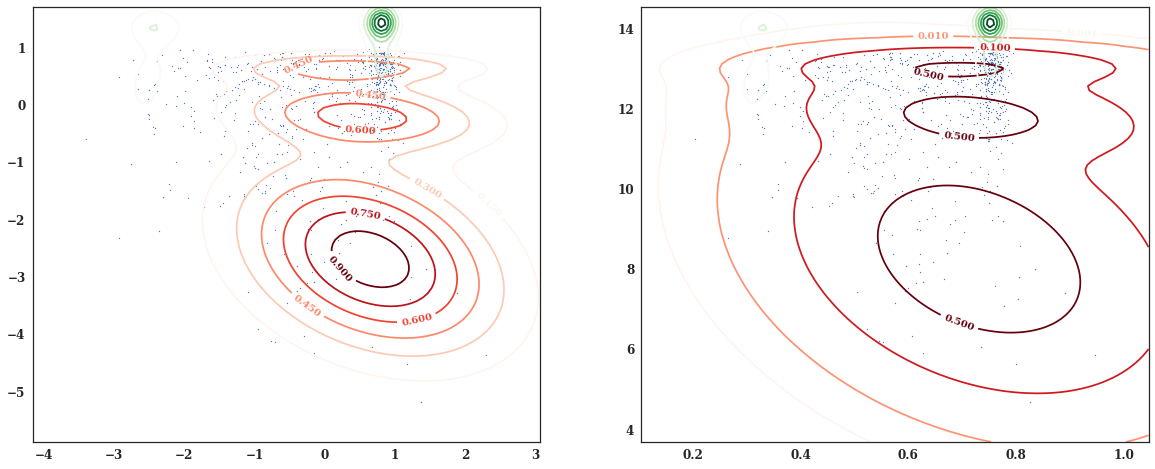

In [18]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f_scaled, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instsf.params_df, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

plt.sca(axes[1])
plt.scatter(instsf.y, instsf.x, s=1)
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds', norm=LogNorm(), levels=(0.001, 0.01, 0.1, 0.5))
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instdf.params_f, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

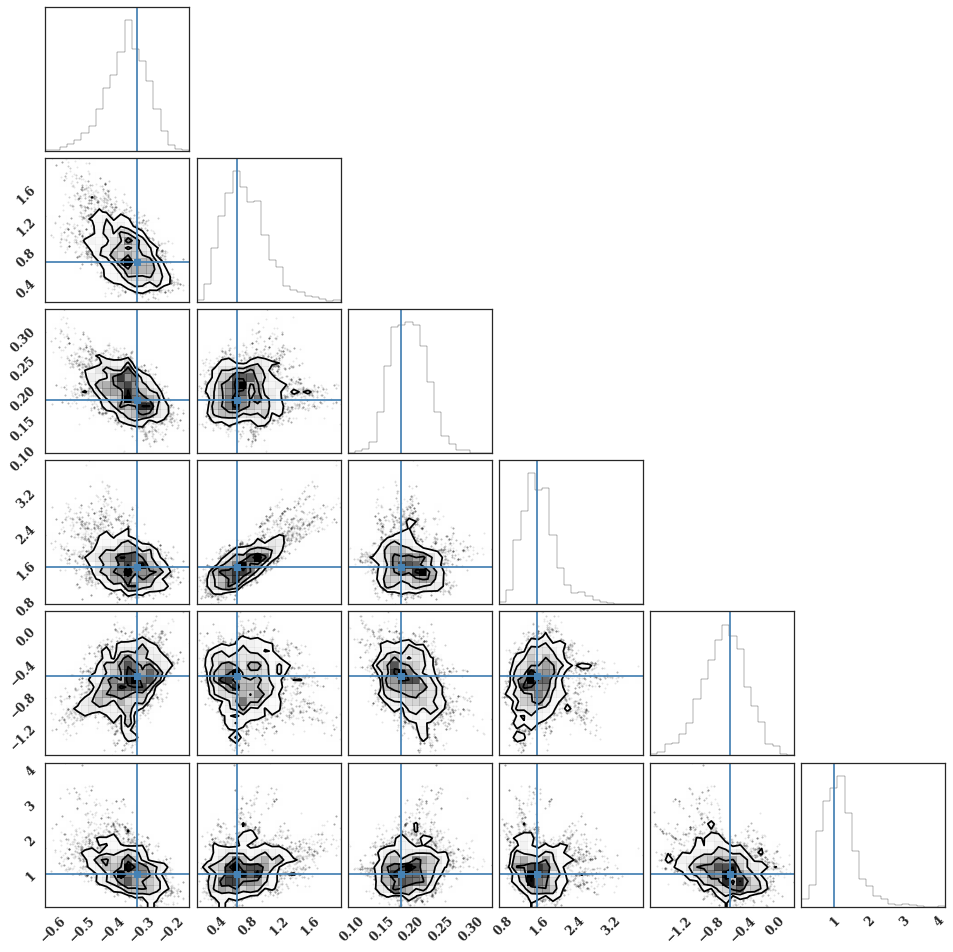

In [64]:
nburn = 500
burnt_values = instsf.sampler.chain[:,nburn::2,:]
burnt_values = burnt_values.reshape(-1, burnt_values.shape[-1])

logitparams = StatisticalModels.transform_sfparams_inv#logit(instsf.params_f_scaled)
_=corner.corner(burnt_values[:,:6], truths = logitparams[0])

# KS test

In [312]:
Xdf = StatisticalModels.feature_scaling(instsf.photoDF.x, instsf.photoDF.y, instsf.mux, instsf.muy, instsf.sx, instsf.sy)
Xdf = np.vstack((Xdf[0], Xdf[1])).T

Xsf = np.vstack((instsf.x_s, instsf.y_s)).T

In [295]:
instsf.params_f_scaled

array([[-2.80776584,  0.29518849,  1.36038071,  1.00112377, -0.20753839,
         6.61345616],
       [-0.19845761,  0.43949559,  0.17542428,  1.33554296, -0.30968627,
         1.91838316],
       [ 0.64542651,  1.321565  ,  0.02757931,  2.36583453, -0.26057084,
         0.92621726]])

In [296]:
def marginal_dist(x, params, axis):
    if axis=='x':
        mu = params[:,0]
        cov = params[:,2]
    elif axis=='y':
        mu = params[:,1]
        cov = params[:,3]
        
    exponent = -0.5*(x[:,np.newaxis]-mu[np.newaxis,:])**2 / (cov[np.newaxis,:])
    norm = 1/np.sqrt(2*np.pi*cov)[np.newaxis,:]
        
    return np.sum(params[:,5][np.newaxis,:]*norm*np.exp(exponent), axis=1)

def marginal_cdf(x, params, axis, normed=False):
    if axis=='x':
        mu = params[:,0]
        cov = params[:,2]
    elif axis=='y':
        mu = params[:,1]
        cov = params[:,3]
        
    components =  0.5*(scipy.special.erf((x[:,np.newaxis] - mu[np.newaxis,:])/(np.sqrt(2*cov[np.newaxis,:]))) + 1)
        
    if normed:
        return np.sum(params[:,5][np.newaxis,:]*components, axis=1)/np.sum(params[:,5])
    return np.sum(params[:,5][np.newaxis,:]*components, axis=1)

def marginal_cdf_bounded(x, params, axis, normed=False, bound=0.):
    if axis=='x':
        mu = params[:,0]
        cov = params[:,2]
    elif axis=='y':
        mu = params[:,1]
        cov = params[:,3]
    
    result = np.zeros(len(x))
    result[x>bound] = 1.
    
    components =  0.5*(scipy.special.erf((x[:,np.newaxis] - mu[np.newaxis,:])/(np.sqrt(2*cov[np.newaxis,:]))) + 1)
    norm = np.sum(params[:,5] * 0.5*(scipy.special.erf((bound - mu)/(np.sqrt(2*cov))) + 1))
        
    print(norm)
        
    if normed:
        result[x<=bound] = np.sum(params[:,5][np.newaxis,:]*components[x<=bound], axis=1)/norm
        return result
    return np.sum(params[:,5][np.newaxis,:]*components, axis=1)

def normed_marginal_cdf(x, params, axis):
    if axis=='x':
        mu = params[:,0]
        cov = params[:,2]
    elif axis=='y':
        mu = params[:,1]
        cov = params[:,3]
        
    components =  0.5*(scipy.special.erf((x - mu)/(np.sqrt(2*cov))) + 1)
        
    return np.sum(params[:,5]*components)/np.sum(params[:,5])

3631.4455120229045


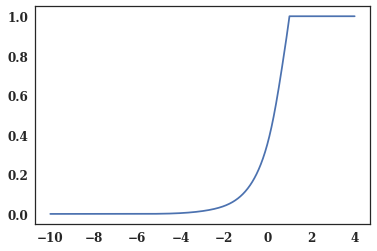

In [297]:
x = np.linspace(-10, 4, 1000)
y = marginal_cdf_bounded(x, instsf.params_df, 'x', normed=True, bound=1)
_=plt.plot(x, y)

In [332]:
params_spec = StatisticalModels.gmm_product_params(instsf.params_f_scaled, instsf.params_df)

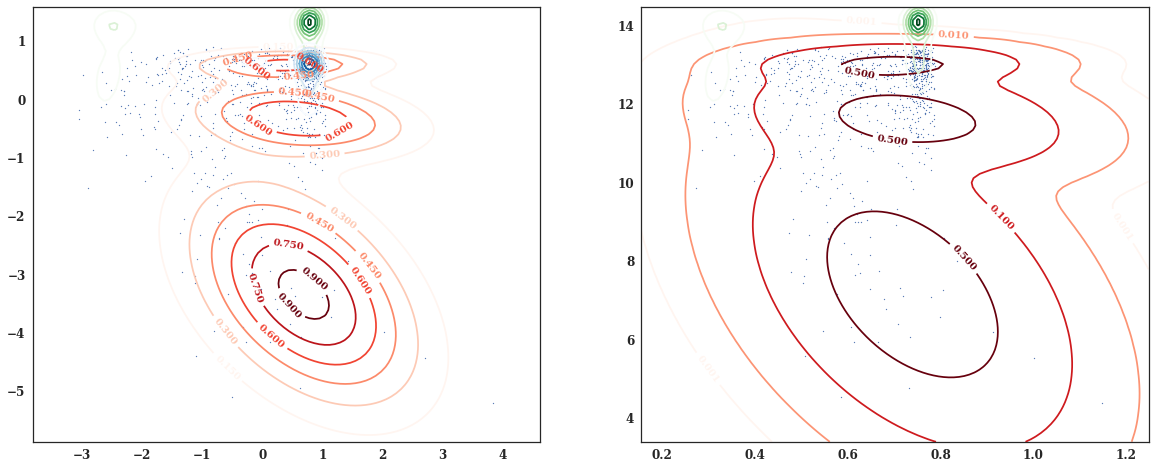

In [130]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f_scaled, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instsf.params_df, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(params_spec, yy, xx)
plt.contour(x, y, zz, cmap='Blues')
#plt.colorbar()

plt.sca(axes[1])
plt.scatter(instsf.y, instsf.x, s=1)
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds', norm=LogNorm(), levels=(0.001, 0.01, 0.1, 0.5))
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instdf.params_f, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

In [78]:
instsf.params_f_scaled

array([[-0.31554903,  0.65122423,  0.18233044,  1.53611144, -0.27714059,
         2.31541366],
       [ 0.60852686,  0.40406306,  0.02987371,  1.13457661,  0.02127529,
         0.70211756],
       [-3.34582719,  0.6890843 ,  1.57376124,  1.56431509, -0.45013316,
         8.38409232]])

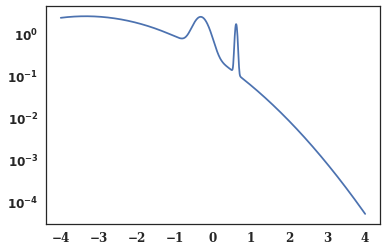

In [84]:
x = np.linspace(-4, 4, 1000)
y = marginal_dist(x, instsf.params_f_scaled, 'x')
_=plt.plot(x, y)
plt.yscale('log')

In [95]:
instsf.params_f_scaled[:,5]

array([2.31541366, 0.70211756, 8.38409232])

In [100]:
marginal_cdf(x, instsf.params_f_scaled[:1], 'x')[-1]

2.3154136579216096

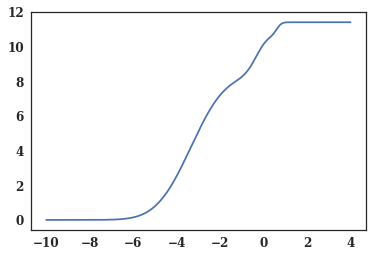

In [103]:
x = np.linspace(-10, 4, 1000)
y = marginal_cdf(x, instsf.params_f_scaled, 'x')
_=plt.plot(x, y)

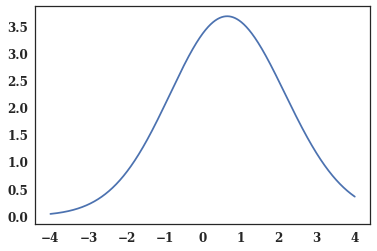

In [86]:
x = np.linspace(-4, 4, 1000)
y = marginal_dist(x, instsf.params_f_scaled, 'y')
_=plt.plot(x, y)
#plt.yscale('log')

In [87]:
import scipy

In [90]:
scipy.special.erf(-1)

-0.8427007929497148

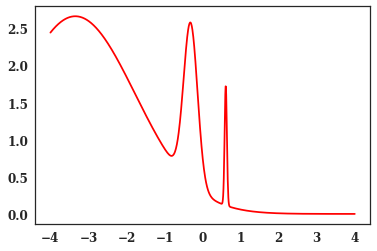

In [115]:
y = marginal_dist(x, instsf.params_f_scaled, 'x')
_=plt.plot(x, y, c='r')

(0.1, 10000.0)

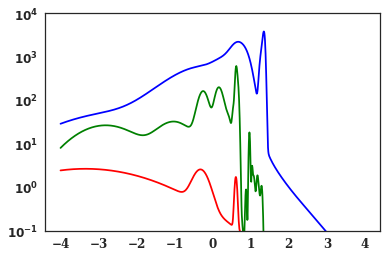

In [120]:
x = np.linspace(-4, 4, 1000)
y = marginal_dist(x, instsf.params_df, 'x')
_=plt.plot(x, y, c='b')

y = marginal_dist(x, instsf.params_f_scaled, 'x')
_=plt.plot(x, y, c='r')

y = marginal_dist(x, params_spec, 'x')
_=plt.plot(x, y, c='g')
plt.yscale('log')

plt.ylim(0.1, 1e4)

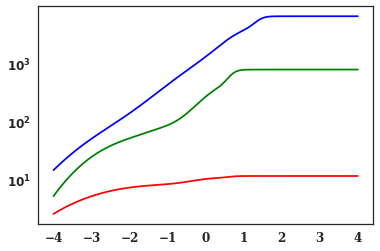

In [119]:
x = np.linspace(-4, 4, 1000)
y = marginal_cdf(x, instsf.params_df, 'x')
_=plt.plot(x, y, c='b')

y = marginal_cdf(x, instsf.params_f_scaled, 'x')
_=plt.plot(x, y, c='r')

y = marginal_cdf(x, params_spec, 'x')
_=plt.plot(x, y, c='g')
plt.yscale('log')

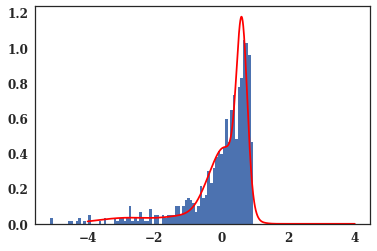

In [316]:
y = marginal_dist(x, params_spec, 'x')
_=plt.plot(x, y/marginal_cdf(x, params_spec, 'x')[-1], c='r')

_=plt.hist(instsf.x_s, bins=80, normed=True)

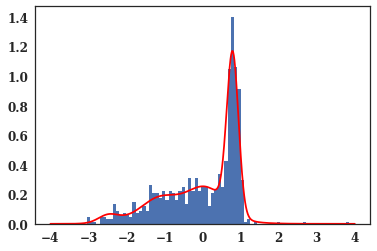

In [209]:
x = np.linspace(-4, 4, 1000)
y = marginal_dist(x, params_spec, 'y')
_=plt.plot(x, y/marginal_cdf(x, params_spec, 'y')[-1], c='r')

_=plt.hist(instsf.y_s, bins=80, normed=True)

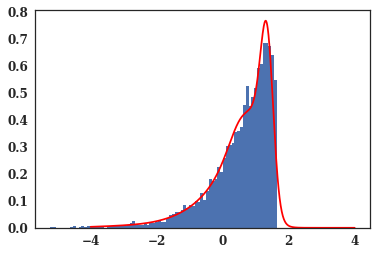

In [315]:
x = np.linspace(-4, 4, 1000)
y = marginal_dist(x, instsf.params_df, 'x')
_=plt.plot(x, y/marginal_cdf(x, instsf.params_df, 'x')[-1], c='r')

_=plt.hist(Xdf[:,0], bins=80, normed=True)

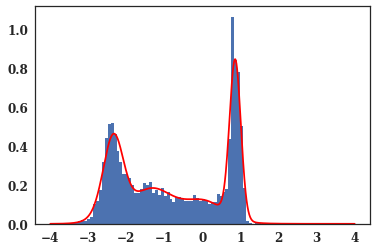

In [313]:
x = np.linspace(-4, 4, 1000)
y = marginal_dist(x, instsf.params_df, 'y')
_=plt.plot(x, y/marginal_cdf(x, instsf.params_df, 'y')[-1], c='r')

_=plt.hist(Xdf[:,1], bins=80, normed=True)

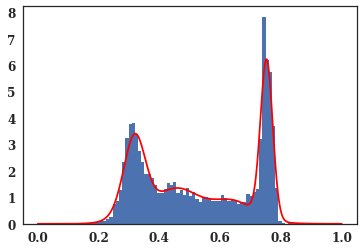

In [314]:
x = np.linspace(0, 1, 1000)
y = marginal_dist(x, instdf.params_f, 'y')
_=plt.plot(x, y/marginal_cdf(x, instdf.params_f, 'y')[-1], c='r')

_=plt.hist(instdf.y, bins=80, normed=True)

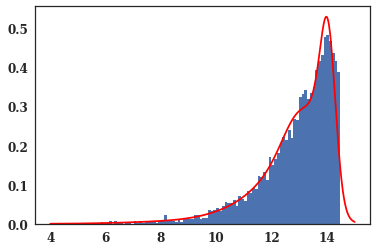

In [309]:
x = np.linspace(4, 15, 1000)
y = marginal_dist(x, instdf.params_f, 'x')
_=plt.plot(x, y/marginal_cdf(x, instdf.params_f, 'x')[-1], c='r')

_=plt.hist(instdf.x, bins=100, normed=True)

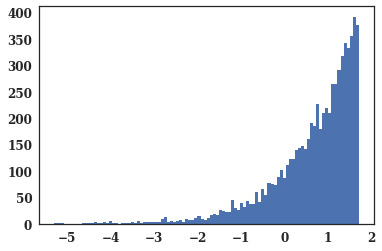

In [221]:
_=plt.hist(Xdf[:,0], bins=100)

In [306]:
x = np.linspace(np.min(instdf.x), np.max(instdf.x), 1000)
foo_cdf = lambda x: marginal_cdf_bounded(x, instdf.params_f, 'x', normed=True, bound=13.5)
ks = scipy.stats.kstest(instdf.x[instdf.x<13.5], foo_cdf)
ks

697.0593221552924


KstestResult(statistic=0.025085408727320124, pvalue=0.022429457469491713)

In [254]:
ks.__dict__

OrderedDict([('statistic', 0.6554621848739496), ('pvalue', 0.0)])

In [317]:
foo_cdf = lambda x: marginal_cdf_bounded(x, instsf.params_df, 'x', normed=True, bound=1)
scipy.stats.kstest(Xdf[:,0][Xdf[:,0]<1], foo_cdf)

3631.4455120229045


KstestResult(statistic=0.025088349834144763, pvalue=0.020157553133808643)

In [318]:
foo_cdf = lambda x: marginal_cdf(x, instsf.params_df, 'x', normed=True)
scipy.stats.kstest(Xdf[:,0], foo_cdf)

KstestResult(statistic=0.024185386825591793, pvalue=0.0015584053008248216)

In [319]:
foo_cdf = lambda x: marginal_cdf(x, instsf.params_df, 'y', normed=True)
scipy.stats.kstest(Xdf[:,1], foo_cdf)

KstestResult(statistic=0.022202877221578543, pvalue=0.004801598926218838)

In [174]:
scipy.stats.kstest?

In [160]:
x_df = np.sort(Xdf[:,1])

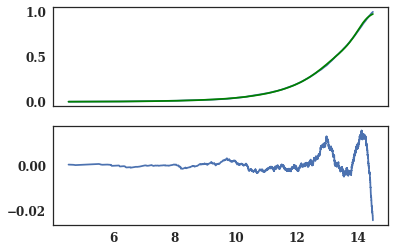

In [320]:
fig, axes = plt.subplots(2,1,sharex=True)

plt.sca(axes[0])
x = np.linspace(np.min(instdf.x), np.max(instdf.x), 1000)
plt.plot(np.sort(instdf.x), np.arange(len(instdf.x))/float(len(instdf.x)))
y = marginal_cdf(x,  instdf.params_f, 'x', normed=True)
_=plt.plot(x, y, c='g')
#plt.yscale('log')

plt.sca(axes[1])
y = marginal_cdf(np.sort(instdf.x), instdf.params_f, 'x', normed=True)
plt.plot(np.sort(instdf.x), y-np.arange(len(instdf.x))/float(len(instdf.x)))

In [250]:
y

array([2.42381719e-04, 2.96189142e-04, 3.71822652e-04, ...,
       9.67961411e-01, 9.68002300e-01, 9.68037389e-01])

KstestResult(statistic=0.024185386825591793, pvalue=0.0015584053008248216)
KstestResult(statistic=0.022202877221578543, pvalue=0.004801598926218838)
697.0593221552924
KstestResult(statistic=0.025085408727320124, pvalue=0.022429457469491713)
KstestResult(statistic=0.022202877221578432, pvalue=0.004801598926219124)


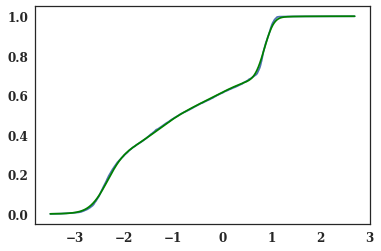

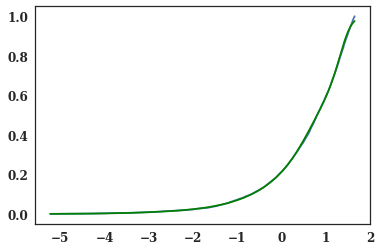

In [331]:
plt.figure()
x = np.linspace(np.min(Xdf[:,1]), np.max(Xdf[:,1]), 1000)
plt.plot(np.sort(Xdf[:,1]), np.arange(len(Xdf[:,1]))/float(len(Xdf[:,1])))
y = marginal_cdf(x, instsf.params_df, 'y', normed=True)
_=plt.plot(x, y, c='g')
#plt.yscale('log')

plt.figure()
x = np.linspace(np.min(Xdf[:,0]), np.max(Xdf[:,0]), 1000)
plt.plot(np.sort(Xdf[:,0]), np.arange(len(Xdf[:,0]))/float(len(Xdf[:,0])))
y = marginal_cdf(x, instsf.params_df, 'x', normed=True)
_=plt.plot(x, y, c='g')

foo_cdf = lambda x: marginal_cdf(x, instsf.params_df, 'x', normed=True)
ksx = scipy.stats.kstest(Xdf[:,0], foo_cdf)
foo_cdf = lambda x: marginal_cdf(x, instsf.params_df, 'y', normed=True)
ksy = scipy.stats.kstest(Xdf[:,1], foo_cdf)

print(ksx)
print(ksy)#, end="\n\n")

foo_cdf = lambda x: marginal_cdf_bounded(x, instdf.params_f, 'x', normed=True, bound=13.5)
ksx = scipy.stats.kstest(instdf.x[instdf.x<13.5], foo_cdf)
foo_cdf = lambda x: marginal_cdf(x, instdf.params_f, 'y', normed=True)
ksy = scipy.stats.kstest(instdf.y, foo_cdf)

print(ksx)
print(ksy)

KstestResult(statistic=0.030513314731406393, pvalue=0.4459807711340308)
KstestResult(statistic=0.05010617543831075, pvalue=0.035675499762756316)


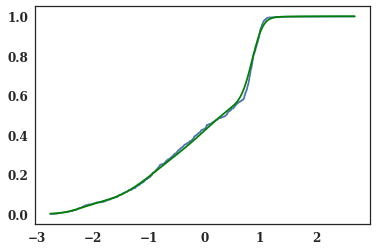

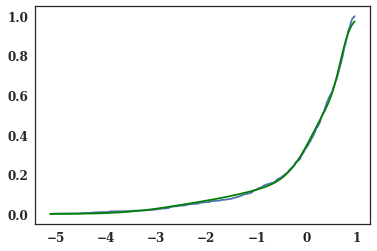

In [336]:
plt.figure()
x = np.linspace(np.min(instsf.y_s), np.max(instsf.y_s), 1000)
plt.plot(np.sort(instsf.y_s), np.arange(len(instsf.y_s))/float(len(instsf.y_s)))
y = marginal_cdf(x, params_spec, 'y', normed=True)
_=plt.plot(x, y, c='g')
#plt.y_sscale('log')

plt.figure()
x = np.linspace(np.min(instsf.x_s), np.max(instsf.x_s), 1000)
plt.plot(np.sort(instsf.x_s), np.arange(len(instsf.x_s))/float(len(instsf.x_s)))
y = marginal_cdf(x, params_spec, 'x', normed=True)
_=plt.plot(x, y, c='g')

foo_cdf = lambda x: marginal_cdf(x, params_spec, 'x', normed=True)
ksx = scipy.stats.kstest(instsf.x_s, foo_cdf)
foo_cdf = lambda x: marginal_cdf(x, params_spec, 'y', normed=True)
ksy = scipy.stats.kstest(instsf.y_s, foo_cdf)

print(ksx)
print(ksy)#, end="\n\n")

KstestResult(statistic=0.030513314731406393, pvalue=0.4459807711340308)
KstestResult(statistic=0.05010617543831086, pvalue=0.035675499762755684)


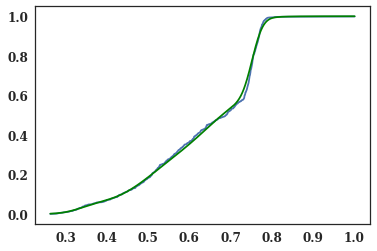

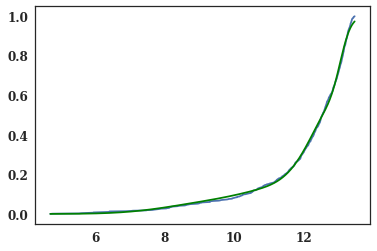

In [337]:
plt.figure()
x = np.linspace(np.min(instsf.y), np.max(instsf.y), 1000)
plt.plot(np.sort(instsf.y), np.arange(len(instsf.y))/float(len(instsf.y)))
y = marginal_cdf(x, instsf.unscaleParams(params_spec), 'y', normed=True)
_=plt.plot(x, y, c='g')
#plt.yscale('log')

plt.figure()
x = np.linspace(np.min(instsf.x), np.max(instsf.x), 1000)
plt.plot(np.sort(instsf.x), np.arange(len(instsf.x))/float(len(instsf.x)))
y = marginal_cdf(x, instsf.unscaleParams(params_spec), 'x', normed=True)
_=plt.plot(x, y, c='g')

foo_cdf = lambda x: marginal_cdf(x, instsf.unscaleParams(params_spec), 'x', normed=True)
ksx = scipy.stats.kstest(instsf.x, foo_cdf)
foo_cdf = lambda x: marginal_cdf(x, instsf.unscaleParams(params_spec), 'y', normed=True)
ksy = scipy.stats.kstest(instsf.y, foo_cdf)

print(ksx)
print(ksy)#, end="\n\n")

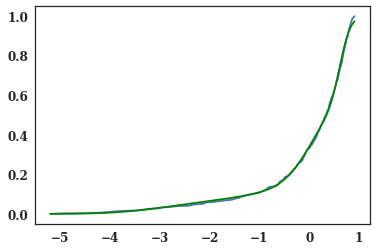

In [218]:
x = np.linspace(np.min(instsf.x_s), np.max(instsf.x_s), 1000)

plt.plot(np.sort(instsf.x_s), np.arange(len(instsf.x_s))/float(len(instsf.x_s)))

y = marginal_cdf(x, params_spec, 'x', normed=True)
_=plt.plot(x, y, c='g')
#plt.yscale('log')

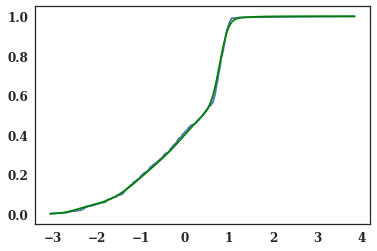

In [171]:
x = np.linspace(np.min(instsf.y_s), np.max(instsf.y_s), 1000)

plt.plot(np.sort(instsf.y_s), np.arange(len(instsf.y_s))/float(len(instsf.x_s)))

y = marginal_cdf(x, params_spec, 'y', normed=True)
_=plt.plot(x, y, c='g')

In [169]:
foo_cdf = lambda x: marginal_cdf(x, params_spec, 'x', normed=True)
scipy.stats.kstest(instsf.x_s, foo_cdf)

KstestResult(statistic=0.028720961066587947, pvalue=0.5365444653030668)

In [170]:
foo_cdf = lambda x: marginal_cdf(x, params_spec, 'y', normed=True)
scipy.stats.kstest(instsf.y_s, foo_cdf)

KstestResult(statistic=0.03963236955183236, pvalue=0.16486528532038205)

In [180]:
instsf.sampler.chain.shape

(36, 1000, 18)

In [181]:
nburn = 500
burnt_values = instsf.sampler.chain[:,nburn::10,:]
burnt_values = burnt_values.reshape(-1, burnt_values.shape[-1])
#logitparams = StatisticalModels.transform_sfparams_invlogit(instsf.params_f_scaled)

[1.64082096 0.28473553 4.38338441]


In [204]:
rand_idx = np.random.choice(np.arange(burnt_values.shape[0]), size=1000)

p_values = np.zeros(rand_idx.shape)
for i in range(len(rand_idx)):
    params_samp = StatisticalModels.transform_sfparams_logit(burnt_values[rand_idx[i]].reshape(-1, 6))
    params_samp_spec = StatisticalModels.gmm_product_params(params_samp, instsf.params_df)

    foo_cdf = lambda x: marginal_cdf(x, params_samp_spec, 'y', normed=True)
    statistic, p_value = scipy.stats.kstest(instsf.y_s, foo_cdf)
    p_values[i] = p_value

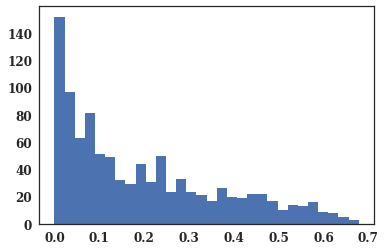

In [205]:
_=plt.hist(p_values, bins=30)

# Testing rootfinder

In [ ]:
%time SF.debug_mode(3.0, part='sf')

In [57]:
i= 5

In [445]:
instsf = SF.obsSF[3.0].SF_model
instdf = SF.obsSF[3.0].DF_model
params_df = instsf.params_df

In [199]:
instsf.photoDF.x

0       12.612837
1        9.223601
2       13.285049
3        9.932564
4        7.369807
5       10.157935
6       13.708370
7       13.084272
8        7.759873
9       11.947723
10      13.006101
11      12.767278
12      14.624977
13      14.065379
14      12.988081
15       7.816197
16      10.375814
17      14.050199
18       9.822008
19      11.651080
20      13.953710
21      14.379319
22      12.200839
23      10.523183
24      13.016259
25      11.570078
26      11.896747
27      10.933229
28      13.580038
29       5.995679
          ...    
7934    13.330199
7935    13.788712
7936    14.342783
7937    10.840458
7938    14.056529
7939    12.471333
7940    14.070567
7941    12.517141
7942    11.266186
7943    14.355811
7944    10.650704
7945    12.813447
7946     9.229517
7947    13.287913
7948    12.278727
7949    12.481584
7950    13.025273
7951    13.374612
7952    10.720024
7953    11.568028
7954    14.179649
7955    11.983419
7956     9.943375
7957    12.788447
7958    13

In [216]:
StatisticalModels.NIW_prior_params(instsf.prior_sfBounds)

Xdf = StatisticalModels.feature_scaling(instsf.photoDF.x, instsf.photoDF.y, instsf.mux, instsf.muy, instsf.sx, instsf.sy)
Xdf = np.vstack((Xdf[0], Xdf[1])).T

Xsf = np.vstack((instsf.x_s, instsf.y_s)).T

weights = 1/StatisticalModels.bivGaussMixture(instsf.params_df, instsf.x_s, instsf.y_s)
# K-Means clustering of initialisation
#print(Xsf.shape, Xdf.shape)
params=StatisticalModels.kmeans_init(Xsf, Xdf, i, weights=weights)
#print(params)
params_kms_pilogit=StatisticalModels.transform_sfparams_invlogit(params)

params_i = params_kms_pilogit

[ 15.30195534   6.99559799 461.76725518   8.59165861   9.20186285]
253865.31237336414


In [208]:
sigma = np.array([[params[:,2], np.sqrt(params[:,2]*params[:,3])*params[:,4]], 
                  [np.sqrt(params[:,2]*params[:,3])*params[:,4], params[:,3]]])
sigma = np.moveaxis(sigma, -1, 0)

In [209]:
sigma_inv, sigma_det = StatisticalModels.quick_invdet(sigma)

In [210]:
sigma_det

array([3.40988497e-01, 1.87614458e-01, 8.38069058e-08, 5.51857844e-01,
       3.57911310e-01])

In [211]:
norm = 1/(2*np.pi*np.sqrt(sigma_det))

In [218]:
params

array([[-4.57838114e+00, -2.15924812e+00,  5.33127486e-01,
         3.67062792e-01, -2.03158080e-01,  5.42482928e-05],
       [-8.71584570e-03, -4.25568918e-02,  5.10411398e-01,
         6.91248992e-01, -1.78422086e-01,  2.48007029e-05],
       [-6.23483069e+00,  3.14626629e+00,  1.11785998e-02,
         1.13251828e-02, -9.99668953e-01,  1.63705126e-03],
       [-4.96592220e+00,  6.24746465e-01,  6.19886637e-01,
         5.82492987e-01,  9.36725232e-02,  3.04590362e-05],
       [-2.14754089e+00, -7.04989334e-01,  4.79745974e-01,
         1.21934765e+00, -2.40577620e-01,  3.26223243e-05]])

In [212]:
StatisticalModels.gradient_rootfinder(params, sigma_inv, norm)

0.9000000000000001

In [186]:
params

array([[-0.00871585, -0.04255689,  1.53123419,  2.07374697, -0.17842209,
         3.        ],
       [-4.57838114, -2.15924812,  1.59938246,  1.10118838, -0.20315808,
         3.        ],
       [-2.14754089, -0.70498933,  1.43923792,  3.65804296, -0.24057762,
         3.        ],
       [-6.23483069,  3.14626629,  0.0335358 ,  0.03397555, -0.99966895,
         3.        ],
       [-4.9659222 ,  0.62474647,  1.85965991,  1.74747896,  0.09367252,
         3.        ]])

In [198]:
Xsf.shape, Xdf.shape

((7964, 2), (7964, 2))

In [205]:
get_spectro_tanh(3.0).shape

(7964, 2)

In [196]:
StatisticalModels.kmeans_init(Xsf, Xdf, i, weights=weights)

63 63 7964 7964
3 3 7964 7964
33 33 7964 7964
1013 1013 7964 7964
6852 6852 7964 7964


array([[-4.9659222 ,  0.62474647,  1.85965991,  1.74747896,  0.09367252,
         3.        ],
       [-6.23483069,  3.14626629,  0.0335358 ,  0.03397555, -0.99966895,
         3.        ],
       [-4.57838114, -2.15924812,  1.59938246,  1.10118838, -0.20315808,
         3.        ],
       [-2.14754089, -0.70498933,  1.43923792,  3.65804296, -0.24057762,
         3.        ],
       [-0.00871585, -0.04255689,  1.53123419,  2.07374697, -0.17842209,
         3.        ]])

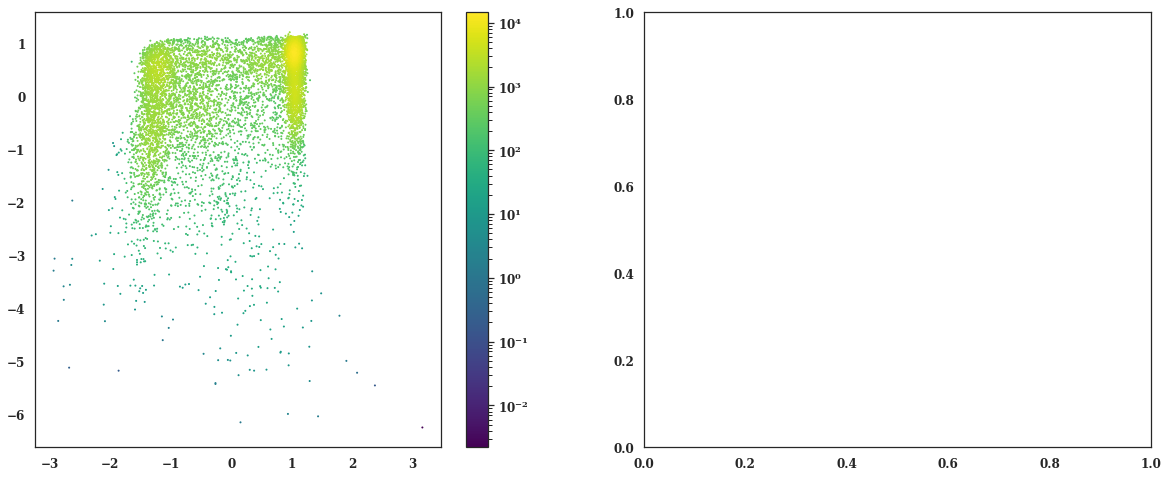

In [191]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, c=1/weights, norm=LogNorm(), cmap='viridis', s=1)
plt.colorbar()

In [222]:
from sklearn.cluster import KMeans

In [263]:
sample = Xsf
df_sample = Xdf
weights = weights
n_components=5


weighted_kde = not weights is None
if weights is None: weights=np.ones(len(sample))

params = np.zeros((n_components, 6))

kmc = KMeans(n_components)
kmc.fit(sample, sample_weight=weights)

labels = kmc.predict(sample)
df_labels = kmc.predict(df_sample)

for i in range(n_components):
    c_sample = sample[labels==i]
    c_df_sample = df_sample[df_labels==i]
    c_weights = weights[labels==i]

    mean = np.sum(c_sample*c_weights[:,np.newaxis], axis=0)/np.sum(c_weights)
    delta = c_sample-mean[np.newaxis, :]
    sigma = np.sum(delta[:,:,np.newaxis]*delta[:,np.newaxis,:]*c_weights[:,np.newaxis,np.newaxis], axis=0)/np.sum(c_weights)

    w = float(len(c_sample))/float(len(c_df_sample))
    #w = np.sum(c_weights)

    if np.sum(labels==i)<=2:
        mu = np.sum(sample*weights[:,np.newaxis], axis=0)/np.sum(weights)
        delta = sample-mu[np.newaxis, :]
        sigma = np.sum(delta[:,:,np.newaxis]*delta[:,np.newaxis,:]*weights[:,np.newaxis,np.newaxis], axis=0)/np.sum(weights)

    multiplier=1.
    params[i, :2] = mean
    params[i, 2:4] = sigma[[0,1],[0,1]]*multiplier
    params[i, 4] = sigma[0,1]/np.sqrt(sigma[0,0]*sigma[1,1])
    params[i, 5] = w * 2*np.pi*np.sqrt(sigma[0,0]*sigma[1,1]*(1-params[i,4]**2)) * multiplier

print(params[:,5])

sigma = np.array([[params[:,2], np.sqrt(params[:,2]*params[:,3])*params[:,4]],
                  [np.sqrt(params[:,2]*params[:,3])*params[:,4], params[:,3]]])
sigma = np.moveaxis(sigma, -1, 0)
sigma_inv, sigma_det = StatisticalModels.quick_invdet(sigma)
norm = 1/(2*np.pi*np.sqrt(sigma_det))
maxima = StatisticalModels.gradient_rootfinder(params, sigma_inv, norm)
print(maxima)
if maxima>=1:
    params[:,5] *= 0.9/maxima

[3.67224899e+00 2.72152933e+00 4.66447723e+00 1.81894586e-03
 3.75895892e+00]
1.004855059421536


In [262]:
norm

array([2.14258095e-01, 2.72522022e-01, 2.66031106e-01, 5.49768976e+02,
       3.67440464e-01])

<a list of 17 text.Text objects>

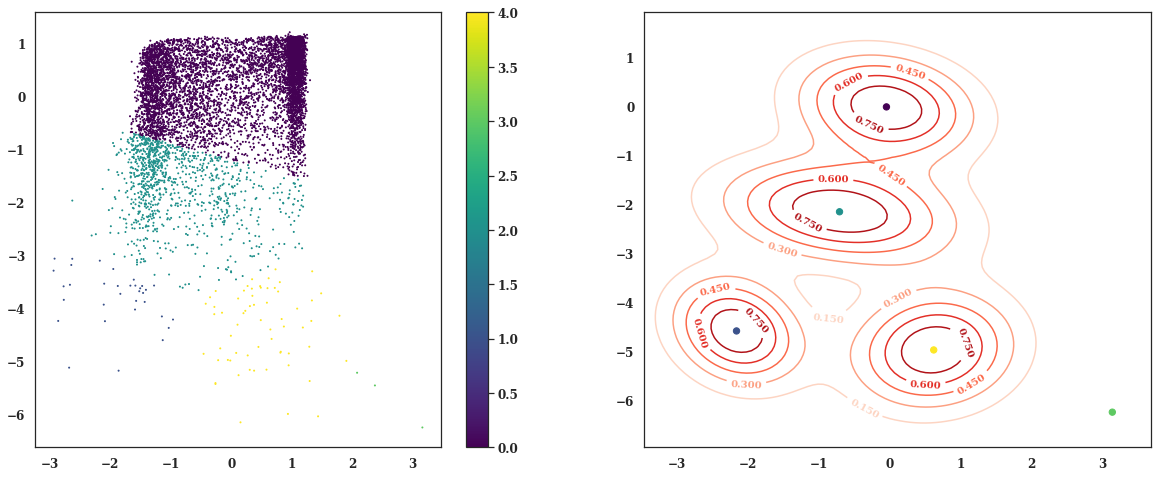

In [264]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, c=labels, cmap='viridis', s=1)
plt.colorbar()

plt.sca(axes[1])
plt.scatter(params[:,1], params[:,0], c=np.arange(n_components), cmap='viridis', s=40)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(params, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)

<a list of 0 text.Text objects>

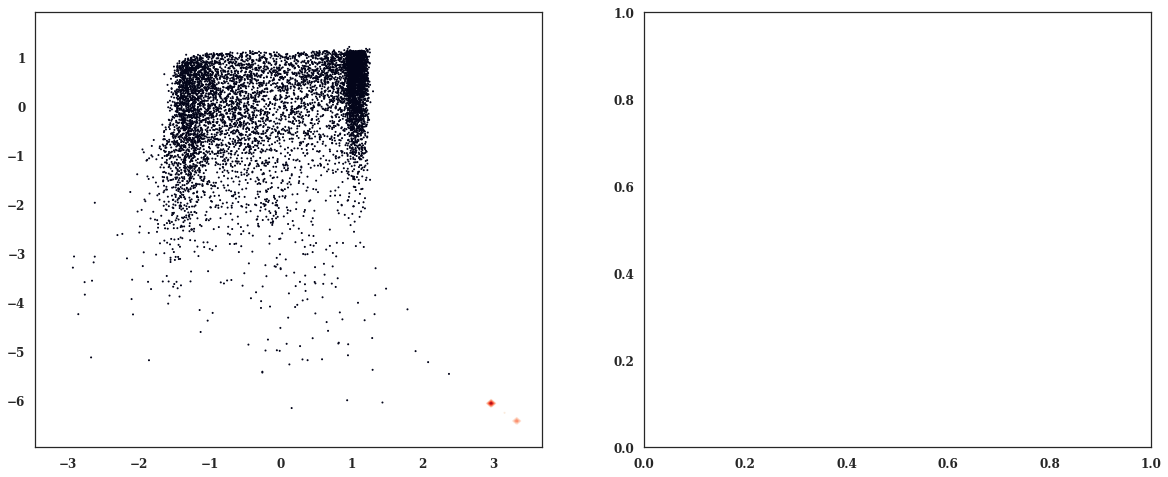

In [217]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, c=weights, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(params, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)

In [69]:
%%time
opt = scipy.optimize.minimize(StatisticalModels.calc_nlnP_grad_pilogit_NIW,  params_i,
                              args=(Xsf, priorParams, instsf.params_df), method='TNC',
                              jac=True, options={'maxiter':1000}, tol=1e-5)
print(opt)

     fun: 7995.812336641861
     jac: array([-3.92787498e+01,  1.16340865e+00, -2.85410454e+01,  3.50029175e+01,
        4.08246101e+00, -2.00438211e+00, -3.98897313e+01, -3.77415243e+01,
       -7.96483685e+00, -5.01617800e+01,  2.11467761e+00, -5.45118233e-02,
       -2.08554327e+01, -1.18437631e+01, -6.00037082e+01, -2.29462719e+01,
       -3.67665647e+00, -5.28515142e-02,  3.99043638e+01, -4.85462628e+01,
        1.05755989e+02,  4.12129452e+01,  2.90557137e+01, -8.38838564e+01,
        2.73288030e-01,  7.20765292e-02,  1.40293041e+02, -3.01622221e+01,
        5.75364684e-01,  1.10587973e-34])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 448
     nit: 22
  status: 1
 success: True
       x: array([-2.49448083,  0.51131076,  2.98630009,  1.92585798,  1.31729463,
        3.83140875, -1.00999406, -1.26089121,  3.21011589,  1.76974168,
        0.92219407,  6.59714524, -5.43434386,  1.67177951,  0.24979731,
        0.61112779, -2.98709079,  4.73400908,  1.02114496,  0.43216196,


In [86]:
%%time
opt = scipy.optimize.minimize(StatisticalModels.calc_nlnP_grad_pilogit_NIW,  params_i,
                              args=(Xsf, priorParams, instsf.params_df), method='TNC',
                              jac=True, options={'maxiter':1000}, tol=1e-5)
print(opt)

/home/andy/Documents/Research/SF/GitRepo/seestar/StatisticalModels.py:2287: RuntimeWarning: invalid value encountered in sqrt
  norm = 1/np.sqrt( ((2*np.pi)**2) * det_cov)


     fun: 9810.871580783041
     jac: array([-3.17259654e+02, -1.92576683e+02,  8.07278686e+01,  1.35363197e+02,
       -1.88267894e+02, -1.00370512e+03, -1.41340449e+03, -5.31889946e+02,
       -5.92669088e+01,  7.58550161e+01, -3.94959356e+02, -4.74064414e+02,
       -1.22504464e+01, -6.93181224e+00, -3.85514029e+03, -3.20550073e+03,
       -3.94209991e+01, -4.05448851e-02, -9.22815803e+01,  4.37245676e+01,
       -2.89486232e+01,  1.67967393e+01,  3.95777020e+01, -8.14611190e+01,
       -1.09166567e+02, -8.95285721e+01, -3.88061352e+01, -2.67558365e-01,
       -6.00869344e+01, -6.42092989e+01])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 158
     nit: 7
  status: 1
 success: True
       x: array([-0.68963083, -0.60738604,  1.69018793,  3.26197415, -0.41211391,
       -0.51198444,  0.21450681,  0.08796009,  0.42247454,  1.20777534,
       -0.24860324,  1.08929083, -6.21671085,  3.1429344 ,  0.87422431,
        1.04380861, -5.82469362,  4.59535736, -4.51829191,  0.60985857,
 

In [87]:
%time SF.debug_mode(3.0, part='sf')

N stars =  7964
Prior boundaries:  [[-6.24807333  1.21476959]
 [-2.93429657  3.15955058]]
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
Bad
False Linear search failed
2    BIC:  20501.38593825802    lnP:  -10196.796849137905
False Linear search failed
3    BIC:  21489.47278588025    lnP:  -10663.89221295347
False Linear search failed
4    BIC:  16672.733983114333    lnP:  -8228.574751574957
True Converged (|f_n-f_(n-1)| ~= 0)
5    BIC:  19881.62075727088    lnP:  -9806.07007865768
True Converged (|f_n-f_(n-1)| ~= 0)
6    BIC:  16390.915424745133   

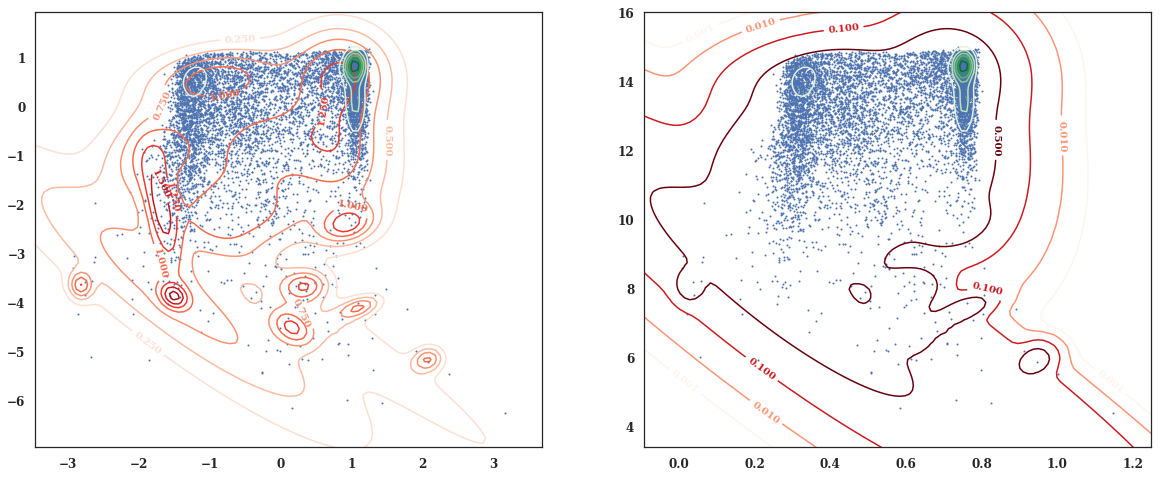

In [112]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f_scaled, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instsf.params_df, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

plt.sca(axes[1])
plt.scatter(instsf.y, instsf.x, s=1)
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds', norm=LogNorm(), levels=(0.001, 0.01, 0.1, 0.5))
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instdf.params_f, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

In [118]:
# Parameters - transform to means, covariances and weights
params = instsf.params_f_scaled.copy()
# means
# covariances
e_alpha = np.exp(-params[...,4])
p = 0.999/(1+e_alpha)
corr = np.sqrt(params[...,2]*params[...,3])*(2*p - 1)
S_sf = np.moveaxis(np.array([[params[...,2], corr], [corr, params[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
e_alpha_pi = np.exp(-params[...,5])
p_pi = 1./(1+e_alpha_pi)
pi = 2*np.pi*np.sqrt(Sdet_sf) * p_pi

# Unscaled parameters
params_original = params.copy()
params_original[:,4] = corr
params_original[:,5] = pi

In [120]:
# Parameters - transform to means, covariances and weights
params = instsf.params_f.copy()

corr = params[...,4]
cov = corr*np.sqrt(params[...,3]*params[...,2])
S_sf = np.moveaxis(np.array([[params[...,2], cov], [cov, params[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
pi = params[...,5]

# Unscaled parameters
params_original = params.copy()
params_original[:,4] = corr
params_original[:,5] = pi

In [ ]:
# Max SF prior
gmm_maxima = gradient_rootfinder(params_original, Sinv_sf, 1/(2*np.pi*np.sqrt(Sdet_sf)))
if gmm_maxima>1:
    return 1e100, params.flatten().copy()*0.#grad.flatten()

In [105]:
Sdet_sf

array([2.04311822e-02, 4.76484737e-03, 2.87710361e-03, 5.62519969e-05,
       2.16362576e-03, 1.55299795e-01, 2.08603110e-04, 3.14523919e-03,
       1.33644583e-04, 1.16678122e-02, 5.15966202e-03, 2.14917172e-03,
       1.24201331e-02, 2.72650062e-03, 5.21665589e-03, 1.04758384e-03])

In [121]:
StatisticalModels.gradient_rootfinder(instsf.params_f, Sinv_sf, 1/(2*np.pi*np.sqrt(Sdet_sf)))

1.898138072405319

In [ ]:
params, Xsf, NIWprior, df_params, stdout=False

In [483]:
%timeit StatisticalModels.calc_nlnP_grad_pilogit_NIW(instsf.params_f_scaled, Xsf, priorParams, instsf.params_df)

7.2 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [501]:
%timeit StatisticalModels.calc_nlnP_pilogit_NIW(instsf.params_f_scaled, Xsf, priorParams, instsf.params_df)

3.54 ms ± 878 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [132]:
StatisticalModels.gradient_rootfinder(instsf.params_f, sigma_inv, norm)

NameError: name 'sigma_inv' is not defined

In [19]:
priorParams = StatisticalModels.NIW_prior_params(instsf.prior_sfBounds)

Xdf = StatisticalModels.feature_scaling(instsf.photoDF.x, instsf.photoDF.y, instsf.mux, instsf.muy, instsf.sx, instsf.sy)
Xdf = np.vstack((Xdf[0], Xdf[1])).T

Xsf = np.vstack((instsf.x_s, instsf.y_s)).T

In [448]:
params = StatisticalModels.transform_sfparams_invlogit(instsf.params_f_scaled)
StatisticalModels.calc_nlnP_grad_pilogit_NIW(params, Xsf, priorParams, instsf.params_df)

(13586.554403498558,
 array([-1.22434933e+02, -1.17109701e+04,  4.07677498e+02, -1.30110551e+05,
        -1.39058629e+02, -1.11971762e+02,  3.44987122e+01,  1.86578439e+02,
        -3.41626546e+02, -1.73956676e+03,  1.93517344e+02, -7.79988188e+02,
        -3.96473367e+02, -4.18155269e+02, -6.34954051e+02,  3.18553264e+00,
        -1.64811740e+02, -6.06774662e+02, -3.73763075e+02, -4.72626442e+01,
         1.81809210e+02,  8.91592443e+02, -3.67830622e+01, -6.02489988e+02,
         1.68253697e+01, -3.24455786e+01, -7.08051667e+00, -5.65411812e+01,
        -9.13923036e+00, -5.75142054e+02]))

In [486]:
params.shape

(3, 6)

In [20]:
import emcee, corner

In [538]:
emcee.__version__

'2.2.1'

In [530]:
corner.corner?

In [33]:
params = StatisticalModels.transform_sfparams_invlogit(instsf.params_f_scaled)
niter = 2000

ndim=len(params.flatten())
nwalkers=ndim*2

p0 = np.repeat([params,], nwalkers, axis=0)
p0 = np.random.normal(loc=p0, scale=np.abs(p0/500))
p0[:,:,2:4] = np.abs(p0[:,:,2:4])

p0 = p0.reshape(nwalkers, -1)
foo = lambda a, b, c, d: -StatisticalModels.calc_nlnP_pilogit_NIW(a, b, c, d)
sampler = emcee.EnsembleSampler(nwalkers, ndim, foo,
                                args=(Xsf, priorParams, instsf.params_df))
# Run emcee
%time _=sampler.run_mcmc(p0, niter)

In [39]:
np.arange(1000)[50::10]

array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300,
       310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430,
       440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560,
       570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690,
       700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820,
       830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950,
       960, 970, 980, 990])

In [43]:
nburn = int(niter/2)
burnt_values = sampler.chain[:,nburn::3,:]
burnt_values = burnt_values.reshape(-1, burnt_values.shape[-1])

median = np.median(burnt_values, axis=0)

lp = sampler.lnprobability
index = np.unravel_index(np.argmax(lp), lp.shape)
median = sampler.chain[index[0], index[1], :]

In [41]:
burnt_values.shape

(6012, 18)

In [534]:
params.shape

(3, 6)

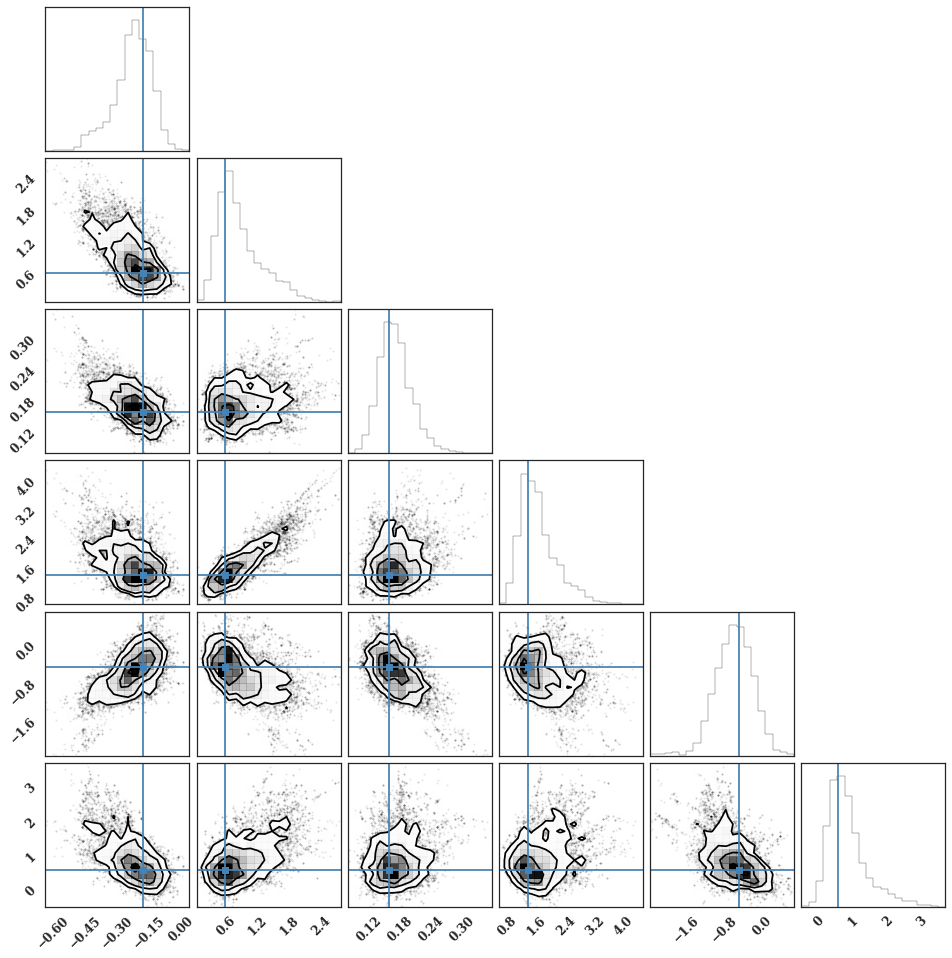

In [44]:
_=corner.corner(burnt_values[:,:6], truths=params[0])

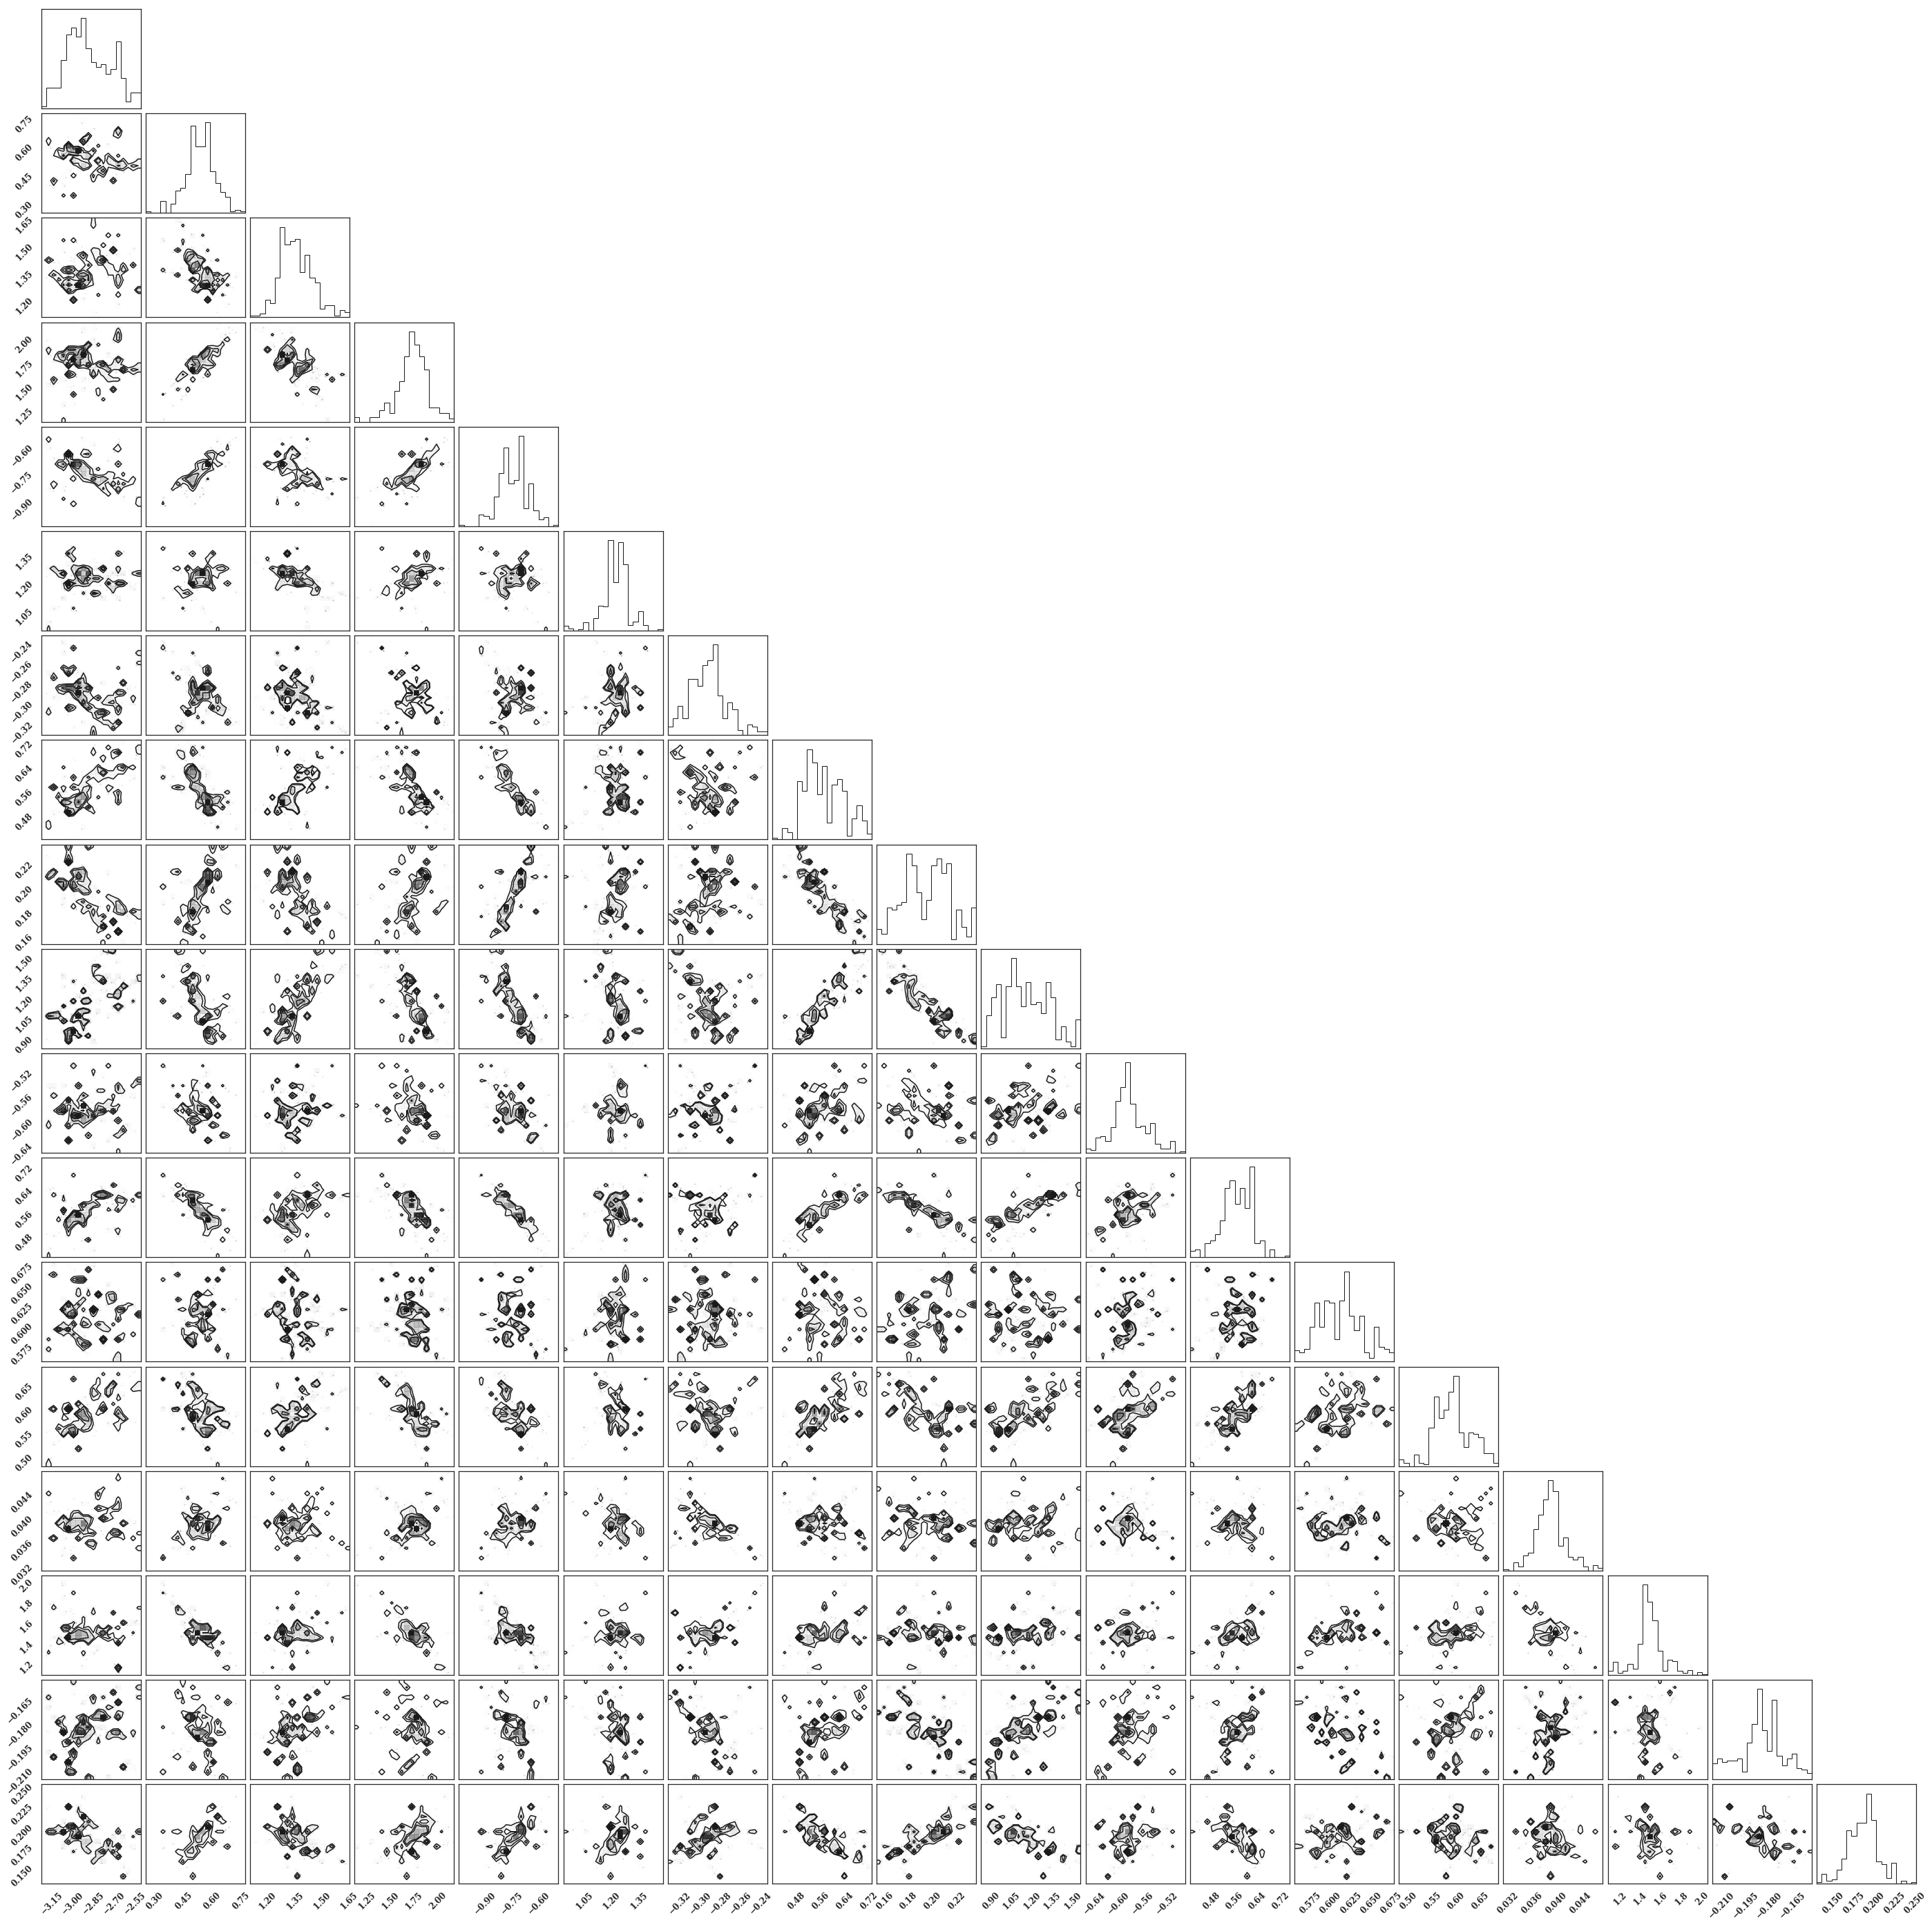

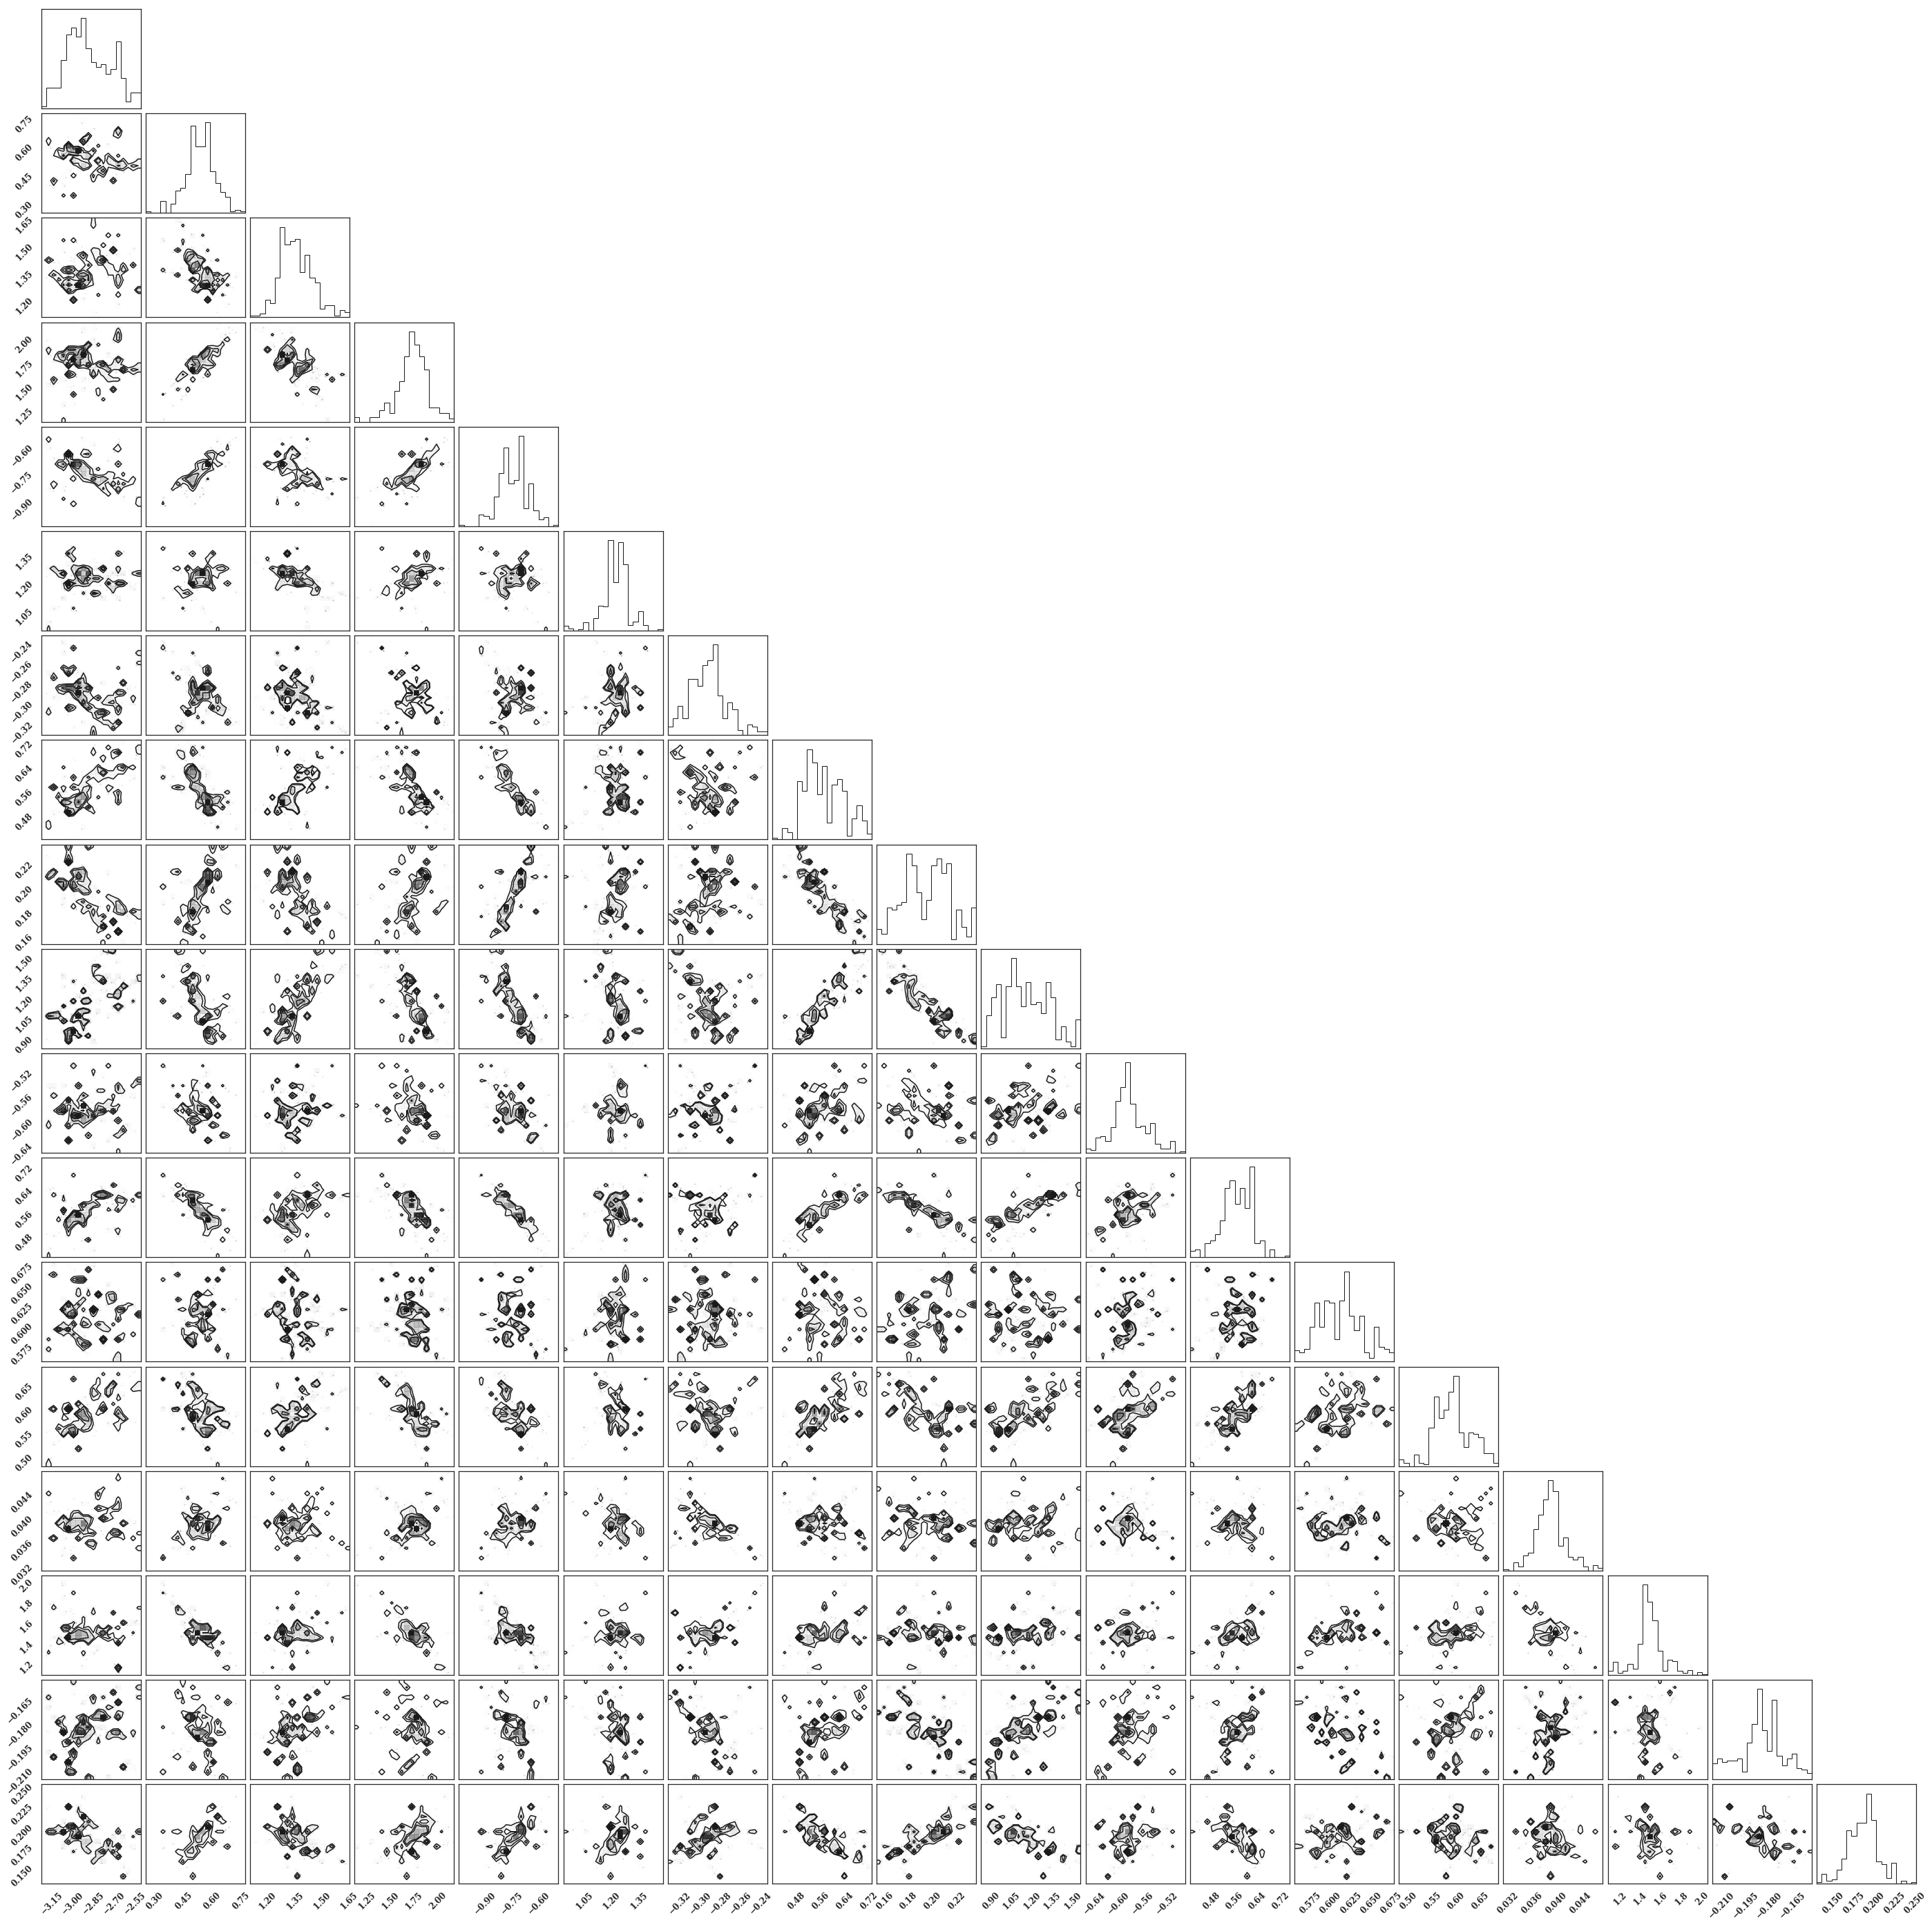

In [522]:
corner.corner(burnt_values)

In [ ]:
corner.corner?

In [54]:
niter=200
params = StatisticalModels.transform_sfparams_invlogit(instsf.params_f_scaled)
%time sampler = StatisticalModels.BGMM_emcee_ball(params, Xsf, priorParams, instsf.params_df, niter=niter)

emcee with 200 iterations...
CPU times: user 15.5 s, sys: 36 ms, total: 15.6 s
Wall time: 15.8 s


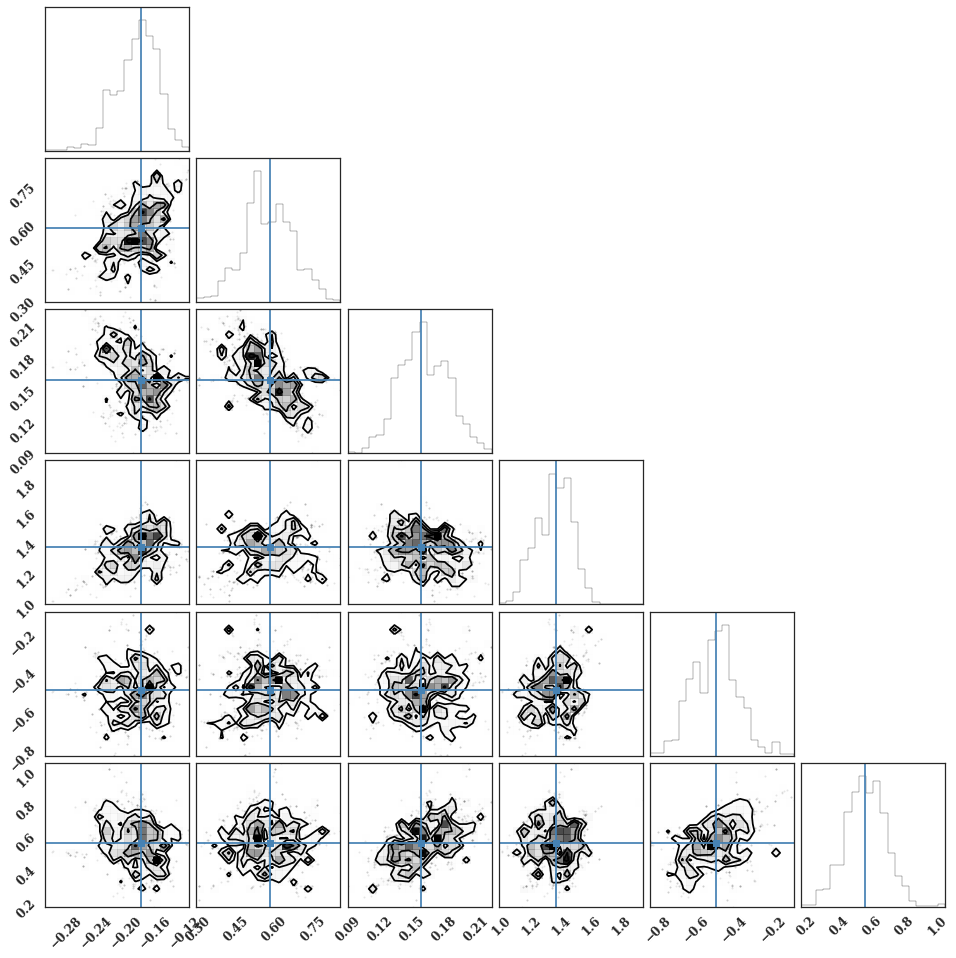

In [55]:
nburn = int(niter/2)
burnt_values = sampler.chain[:,nburn::2,:]
burnt_values = burnt_values.reshape(-1, burnt_values.shape[-1])

_=corner.corner(burnt_values[:,:6], truths = params[0])

In [135]:
# Parameters - transform to means, covariances and weights
params = np.reshape(params, (-1,6))
# means
params[:,2:4] = np.abs(params[:,2:4])
# covariances
e_alpha = np.exp(-params[...,4])
p = 0.999/(1+e_alpha)
corr = np.sqrt(params[...,2]*params[...,3])*(2*p - 1)
S_sf = np.moveaxis(np.array([[params[...,2], corr], [corr, params[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
e_alpha_pi = np.exp(-params[...,5])
p_pi = 1./(1+e_alpha_pi)
pi = 2*np.pi*np.sqrt(Sdet_sf) * p_pi

In [136]:
# Unscaled parameters
params_original = params.copy()
params_original[:,4] = corr
params_original[:,5] = pi

In [140]:
Sdet_sf

array([9.38212917e-02, 1.06313467e-02, 2.39712358e-03, 4.20198330e-03,
       8.36357237e-02, 5.08800084e-01, 2.13912070e-01, 2.45185910e-03,
       2.55340508e+00, 2.90222111e-01, 8.70548130e-02, 4.51367489e-04,
       2.49547006e-01, 8.92812243e-04, 5.03293570e-04, 6.78088709e-04])

In [138]:
StatisticalModels.gradient_rootfinder(params_original, Sinv_sf, 1/(2*np.pi*np.sqrt(Sdet_sf)))

/home/andy/Documents/Research/SF/GitRepo/seestar/StatisticalModels.py:2285: RuntimeWarning: invalid value encountered in sqrt
  # Normalisation term


nan

In [141]:
1/(2*np.pi*np.sqrt(Sdet_sf))

array([0.51960034, 1.5435688 , 3.25068524, 2.45523446, 0.55033131,
       0.22312413, 0.34411411, 3.21419615, 0.09960021, 0.2954302 ,
       0.53941589, 7.49126214, 0.31859866, 5.32647709, 7.09429822,
       6.11190894])

In [ ]:
# Max SF prior
gmm_maxima = gradient_rootfinder(params_original, Sinv_sf, 1/(2*np.pi*np.sqrt(Sdet_sf)))
if gmm_maxima>1:
    return 1e100, params.flatten().copy()*0.#grad.flatten()

In [144]:
cov = params_original[:,4] * np.sqrt(params_original[:,2]*params_original[:,3])

In [147]:
sigma = np.array([[params_original[:,2], cov],[cov, params_original[:,3]]])
sigma = np.moveaxis(sigma, -1, 0)

In [149]:
StatisticalModels.quick_invdet(sigma)[1]

array([ 9.44013708e-02,  1.55398844e-02,  2.41370152e-03,  4.50173198e-03,
        8.87367416e-02, -7.00143937e+01,  2.15919720e-01,  2.96117850e-03,
       -1.29579556e+02,  2.94009751e-01,  8.96616689e-02,  4.51596089e-04,
        2.50571481e-01,  1.16101900e-03,  5.32814580e-04,  6.87819138e-04])

In [151]:
params_original[:,4]

array([-2.53098893e-02, -7.06145476e-02,  4.07652446e-03,  1.73523653e-02,
        7.48385946e-02, -2.94057808e+00, -5.06194459e-02, -2.26016114e-02,
       -3.27786797e+00, -7.33287707e-02,  5.35203005e-02, -4.78228996e-04,
        3.69815523e-02,  1.63865371e-02, -5.43477212e-03,  3.12043685e-03])

In [152]:
2*p - 1

array([-0.08234969, -0.56504729,  0.0829745 ,  0.25858508,  0.25052684,
       -0.97181719, -0.1087963 , -0.41523711, -0.89887888, -0.1348723 ,
        0.1784811 , -0.02250405,  0.07382818,  0.48084954, -0.23544359,
        0.1189806 ])

In [142]:
StatisticalModels.bivGaussMixture(params_original, Xsf[:,0], Xsf[:,1])

/home/andy/Documents/Research/SF/GitRepo/seestar/StatisticalModels.py:2285: RuntimeWarning: invalid value encountered in sqrt
  # Normalisation term


array([nan, nan, nan, ..., nan, nan, nan])

In [164]:
params_i

array([[-4.9659222 ,  0.62474647,  1.85965991,  1.74747896,  0.18789591,
        -1.01485341],
       [-4.57838114, -2.15924812,  1.59938246,  1.10118838, -0.4120488 ,
        -0.54321304],
       [-0.00871585, -0.04255689,  1.53123419,  2.07374697, -0.36070483,
        -0.98292044],
       [-2.14754089, -0.70498933,  1.43923792,  3.65804296, -0.49077425,
        -1.29868569],
       [-6.23483069,  3.14626629,  0.0335358 ,  0.03397555, -8.70623318,
         4.59511985]])

In [165]:
# means
params_i[:,2:4] = np.abs(params_i[:,2:4])
# covariances
e_alpha = np.exp(-params_i[...,4])
p = 0.999/(1+e_alpha)
corr = (2*p - 1)
cov = np.sqrt(params_i[...,2]*params_i[...,3])*corr
S_sf = np.moveaxis(np.array([[params_i[...,2], cov], [cov, params_i[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params_i[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
e_alpha_pi = np.exp(-params_i[...,5])
p_pi = 1./(1+e_alpha_pi)
pi = 2*np.pi*np.sqrt(Sdet_sf) * p_pi

In [166]:
pi

array([3.00030824, 2.9994924 , 2.9995447 , 2.99941725, 0.00539957])

In [315]:
StatisticalModels.calc_nlnP_grad_pilogit_NIW(params_i, Xsf, priorParams, instsf.params_df) 

(181271.24080320698,
 array([-8.06719088e+01, -5.70352367e+01, -4.74348480e+01, -1.06731924e+01,
        -2.37484681e+01, -3.99248071e+01, -4.85811501e+03, -2.56559800e+03,
        -2.94491202e+02, -2.80813193e+03, -1.87045984e+03, -6.73654389e+03,
        -8.86836990e+01, -8.89838912e+01, -1.05309857e+10, -1.03932905e+10,
        -7.79245924e+04, -9.99995194e-02, -6.77948920e+01,  2.05566072e+01,
        -1.75021736e+01,  2.78577410e+01,  1.27652702e+01, -6.57119758e+01,
        -1.48797261e+03, -1.05360146e+02, -1.04792290e+03,  2.45802329e+02,
        -4.03628122e+01, -1.12074310e+03]))

In [345]:
opt = scipy.optimize.minimize(StatisticalModels.calc_nlnP_grad_pilogit_NIW,  params_i,
                              args=(Xsf, priorParams, instsf.params_df), method='TNC',
                              jac=True, options={'maxiter':1000}, tol=1e-5)
print(opt)

Max val: 0.9000000000000241
181271.24080320698
Max val: 0.9000000000000445
181271.16672669025
Max val: 0.9000000000000593
181271.240900181
Max val: 0.8999999999998661
181151.29947536328
Max val: 0.8999999999999778
180557.08397413418
Max val: 0.8999999999999654
168176.74274403462
Max val: 0.9000000000069948
106372.44428745794
Max val: 0.9000000000034613
109176.83263616402
Max val: 0.9000000000017127
114087.32675509498
Max val: 0.9000000000008177
121806.46584500073
Max val: 0.9000000000004972
132104.06279991133
Max val: 0.9000000000005737
132104.06275588027
Max val: 0.9000000000003566
132104.0627998675
Max val: 0.9000000000008489
132016.6557199991
Max val: 0.9000000000021966
131587.43618492602
Max val: 0.9000000000375343
123886.87631635364
Max val: 0.9000000044444301
103331.97293727608
Max val: 0.9000000022408676
104240.11591529923
Max val: 0.9000000011392034
105354.30336814885
Max val: 0.900000000588232
107151.25688543814
Max val: 0.9000000003129426
109841.32270896685
Max val: 0.9000000

In [346]:
StatisticalModels.calc_nlnP_grad_pilogit_NIW(opt.x.reshape(-1,6).copy(), Xsf, priorParams, instsf.params_df)

Max val: 0.9999999999999994
9097.674229922066


(9097.674229922066,
 array([ 3.03477058e-02,  5.07600241e-02,  2.22398170e+01,  3.27578584e+01,
         2.15050166e+00, -4.27715468e-02, -5.42717805e+02, -3.36771455e+02,
         5.67525368e+02,  1.58506655e+02, -1.97613069e+02, -4.20077895e+01,
        -2.13267981e+02, -2.83905718e+01, -9.03583576e+01, -2.78947491e+01,
        -7.85143052e+01, -4.55240219e+01, -4.02441885e-03,  2.28029230e-03,
         1.89559424e+01,  2.05041164e+01, -1.02937015e+00, -9.25280373e-04,
        -9.39334099e-03,  7.88944531e-05,  2.40766543e+01,  1.03721673e+01,
         2.64616979e+00, -1.88069447e-02]))

In [324]:
# Parameters - transform to means, covariances and weights
params = np.reshape(opt.x, (-1,6)).copy()
# means
params[:,2:4] = np.abs(params[:,2:4])
# covariances
e_alpha = np.exp(-params[...,4])
p = (1-1e-10)/(1+e_alpha)
corr = (2*p - 1)
cov = np.sqrt(params[...,2]*params[...,3])*corr
S_sf = np.moveaxis(np.array([[params[...,2], cov], [cov, params[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
e_alpha_pi = np.exp(-params[...,5])
p_pi = 1./(1+e_alpha_pi)
pi = 2*np.pi*np.sqrt(Sdet_sf) * p_pi

# Unscaled parameters
params_original = params.copy()
params_original[:,4] = corr
params_original[:,5] = pi
# Max SF prior
gmm_maxima = StatisticalModels.gradient_rootfinder(params_original, Sinv_sf, 1/(2*np.pi*np.sqrt(Sdet_sf)))
print('Max val:', gmm_maxima)

Max val: 1.1453417906841987


In [312]:
params = StatisticalModels.transform_sfparams_logit(opt.x.reshape(-1, 6))

[3.83140875 6.59714524 4.73400908 0.43207702 0.31886691]


In [307]:
sigma = np.array([[params[:,2], np.sqrt(params[:,2]*params[:,3])*params[:,4]],
                  [np.sqrt(params[:,2]*params[:,3])*params[:,4], params[:,3]]])
sigma = np.moveaxis(sigma, -1, 0)
sigma_inv, sigma_det = StatisticalModels.quick_invdet(sigma)
norm = 1/(2*np.pi*np.sqrt(sigma_det))

In [308]:
StatisticalModels.gradient_rootfinder(params, sigma_inv, norm, all_maxima=True)

(array([1.14534179, 1.12298033, 1.01185775, 1.13421232, 0.57904808]),
 array([[-2.28562647,  0.18000226],
        [-0.78617899, -0.84569884],
        [-5.40886423,  1.63097155],
        [ 0.34164261, -0.29497517],
        [12.8786082 ,  1.77832145]]))

In [313]:
params[:,:2]

array([[-2.49448083,  0.51131076],
       [-1.00999406, -1.26089121],
       [-5.43434386,  1.67177951],
       [ 1.02114496,  0.43216196],
       [12.8786082 ,  1.77832145]])

In [280]:
opt.x.reshape(-1,6)

array([[-2.49448083,  0.51131076,  2.98630009,  1.92585798,  1.31729463,
         3.83140875],
       [-1.00999406, -1.26089121,  3.21011589,  1.76974168,  0.92219407,
         6.59714524],
       [-5.43434386,  1.67177951,  0.24979731,  0.61112779, -2.98709079,
         4.73400908],
       [ 1.02114496,  0.43216196,  1.13987851,  2.03896462, -0.31666035,
         0.43207702],
       [12.8786082 ,  1.77832145,  0.05600965,  0.01845491,  0.07849384,
         0.31886691]])

In [284]:
opt.x.reshape(-1,6) - StatisticalModels.transform_sfparams_invlogit(params)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.73330707e-07, 6.66133815e-15],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.51480173e-07, 4.35207426e-14],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.05043400e-07, 1.50990331e-14],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.72857820e-07, 1.11022302e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.08165668e-07, 0.00000000e+00]])

In [314]:
params[:,5] * norm

array([0.97878096, 0.9986376 , 0.99128546, 0.60636953, 0.57904808])

In [298]:
# Parameters - transform to means, covariances and weights
params = opt.x.reshape(-1, 6).copy()
# means
params[:,2:4] = np.abs(params[:,2:4])
# covariances
e_alpha = np.exp(-params[...,4])
p = (1-1e-10)/(1+e_alpha)
corr = (2*p - 1)
cov = np.sqrt(params[...,2]*params[...,3])*corr
S_sf = np.moveaxis(np.array([[params[...,2], cov], [cov, params[...,3]]]), -1, 0)
Sinv_sf, Sdet_sf = StatisticalModels.quick_invdet(S_sf)
#weights
# Logit correction of params[:,5] - [-inf, inf] --> [0, rt(det(2.pi.S))]
e_alpha_pi = np.exp(-params[...,5])
p_pi = 1./(1+e_alpha_pi)
pi = 2*np.pi*np.sqrt(Sdet_sf) * p_pi

# Unscaled parameters
params_original = params.copy()
params_original[:,4] = corr
params_original[:,5] = pi

In [299]:
params_original

array([[-2.49448083,  0.51131076,  2.98630009,  1.92585798,  0.5774625 ,
        12.0408288 ],
       [-1.00999406, -1.26089121,  3.21011589,  1.76974168,  0.4309779 ,
        13.49534862],
       [-5.43434386,  1.67177951,  0.24979731,  0.61112779, -0.90397503,
         1.04054585],
       [ 1.02114496,  0.43216196,  1.13987851,  2.03896462, -0.15702028,
         5.73628099],
       [12.8786082 ,  1.77832145,  0.05600965,  0.01845491,  0.03922678,
         0.11688196]])

In [302]:
params

array([[-2.49448083,  0.51131076,  2.98630009,  1.92585798,  0.5774625 ,
        12.0408288 ],
       [-1.00999406, -1.26089121,  3.21011589,  1.76974168,  0.4309779 ,
        13.49534862],
       [-5.43434386,  1.67177951,  0.24979731,  0.61112779, -0.90397503,
         1.04054585],
       [ 1.02114496,  0.43216196,  1.13987851,  2.03896462, -0.15702028,
         5.73628099],
       [12.8786082 ,  1.77832145,  0.05600965,  0.01845491,  0.03922678,
         0.11688196]])

In [301]:
StatisticalModels.transform_sfparams_logit(opt.x.reshape(-1,6))

[3.83140875 6.59714524 4.73400908 0.43207702 0.31886691]


array([[-2.49448083,  0.51131076,  2.98630009,  1.92585798,  0.5774625 ,
        12.0408288 ],
       [-1.00999406, -1.26089121,  3.21011589,  1.76974168,  0.4309779 ,
        13.49534862],
       [-5.43434386,  1.67177951,  0.24979731,  0.61112779, -0.90397503,
         1.04054585],
       [ 1.02114496,  0.43216196,  1.13987851,  2.03896462, -0.15702028,
         5.73628099],
       [12.8786082 ,  1.77832145,  0.05600965,  0.01845491,  0.03922678,
         0.11688196]])